In [1]:
import matplotlib.pyplot as plt
import pde
import pandas as pd
import numpy as np
import torch
torch.manual_seed(0)

import pandas as pd
from torch.nn import functional as F


from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

plt.rcParams['figure.figsize'] = [6, 6]

[gallirium:62113] pml_ucx.c:329  Warning: UCP worker does not support MPI_THREAD_MULTIPLE. PML UCX could not be selected


In [2]:
def solveEquationPYPDE(variable, eq, ic="2/cosh(x)**2", xrange=None, yrange=None, points=300, trange=pi/2):
    #initialize xrangenp.linspace(0, 10, 100).reshape(-1, 1)
    if xrange is None:
        xrange = [-5, 5]

    # define an interval
    int = trange/300
    
    #eq is passed in as a string with x as the dependent variable
    eq = pde.PDE({variable: eq})
    
    if yrange is not None:
        grid = pde.grids.CartesianGrid([xrange, yrange], [points], periodic=[True, True])
    else:
        grid = pde.grids.CartesianGrid([xrange], [points],  periodic=True)
    
    field = pde.ScalarField.from_expression(grid, ic)
    bc = ["periodic", {'derivative': 'periodic'}]
    #field /= np.sqrt(field.to_scalar('norm_squared').integral.real)

    storage = pde.MemoryStorage()
    trackers = ['progress', storage.tracker(interval=int)]
    
    solver = pde.ExplicitSolver(eq, backend='numba' ,scheme='runge-kutta', adaptive=True, tolerance=1e-9)
    controller = pde.Controller(solver, t_range=trange, tracker=trackers)
    solution = controller.run(field, dt=1e-5)
    
    return field, storage

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.5707963267948966/1.5707963267948966 [00:10<00:00,  6.80s/it]


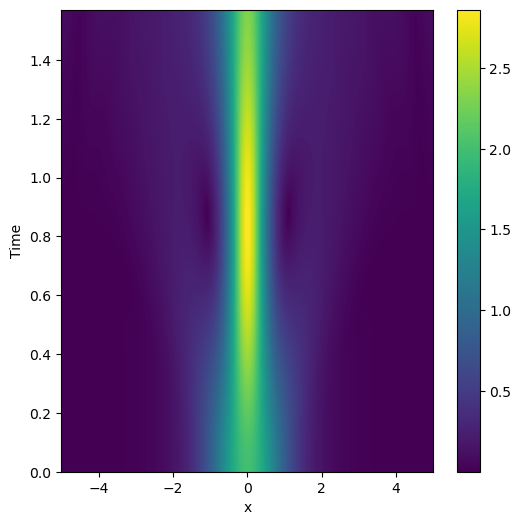

In [3]:
s1, st1 = solveEquationPYPDE('phi', f"0.5 * I * laplace(phi) + I * (phi*conjugate(phi)) * phi")
pde.plot_kymograph(st1)

In [4]:
numerical = np.array(st1.data)[:300,:]
real = numerical.real
imag = numerical.imag
numabs = np.sqrt(real**2 + imag**2)

In [5]:
def preds_and_errors_nse(model, err=1):
    pred = model.net(xt_pairs)
    absval = torch.sqrt(pred[:,0:1]**2 + pred[:,1:2]**2).reshape((300,300)).detach().cpu()
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, layout='constrained')
    fig.set_figwidth(12)
    #fig.suptitle('Horizontally stacked subplots')
    ax1.set_title("Predicted")
    ax1.set_xlabel("x")
    ax1.set_ylabel("t")
    p1 = ax1.pcolormesh(x_grid.numpy(), t_grid.numpy(), absval.numpy())
    plt.colorbar(p1, ax=ax1)
    ax2.set_title("Error")
    ax2.set_xlabel("x")
    p2 = ax2.pcolormesh(x_grid.numpy(), t_grid.numpy(),  np.abs(absval.numpy()-numabs)/err)
    plt.colorbar(p2, ax=ax2)

In [6]:
x = s1.get_line_data()['data_x'].reshape(-1,1) # X x 1
t = np.array(st1.times).reshape(-1,1) # T x 1
x_grid, t_grid = np.meshgrid(x, t)


phi = np.array(st1.data)
u = np.real(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)   #.flatten()[:,None]
v = np.imag(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)  #.flatten()[:,None]
#plt.pcolormesh(x_grid, t_grid, np.sqrt(u**2 + v**2))

##Generate the two indices
idx1 = np.random.choice(x_grid.shape[0], 100, replace=False)
idx1 = np.sort(idx1)
idx2 = np.random.choice(x_grid.shape[1], 105, replace=False)
idx2 = np.sort(idx2)

def gen_train(grid):
    grid_new = grid[idx1]
    grid_new = grid_new[:,idx2]
    return grid_new
    
x_train, t_train, u_train, v_train = gen_train(x_grid), gen_train(t_grid), gen_train(u), gen_train(v)

In [7]:
## reshape to feed into model
x_train = x_train.flatten()[:,None]
t_train = t_train.flatten()[:,None]

u_train = u_train.flatten()[:,None]
v_train = v_train.flatten()[:,None]

In [8]:
## boilerplate stuff for GPU...
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

## create gridmesh for plotting
x_axis = torch.linspace(-5, 5, 300, dtype=torch.float32) #,dtype=torch.float16)
t_axis = torch.linspace(0, pi/2, 300, dtype=torch.float32) #, dtype=torch.float16)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

class PINN():
    def __init__(self, x, t, u, v, dDim=256, nHid=4, lr=1e-4, path=None):
        self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True, device=device) #, dtype=torch.float16,
        self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True, device=device) #, dtype=torch.float16,
        
        self.u = torch.tensor(u, dtype=torch.float32, device=device)
        self.v = torch.tensor(v, dtype=torch.float32, device=device)
        
        self.null = torch.zeros((self.x.shape[0],1), dtype=torch.float32, device=device) ##  dtype=torch.float16,

        self.dDim = dDim
        self.nHid = nHid
        self.lr = lr
        self.mse = torch.nn.MSELoss()
        
        ## Attempt to load the model
        if path:
            checkpoint = torch.load(path)
            ## Initialize the net and load the state_dict, same for the optimizer
            self.net_init()
            self.net.load_state_dict(checkpoint['model_state_dict'])
            
            self.lam1 = checkpoint['lam1']
            self.lam2 = checkpoint['lam2']
            self.lams1 = checkpoint['lams1']
            self.lams2 = checkpoint['lams2']
            self.optim = torch.optim.Adam(list(self.net.parameters()) + [self.lam1, self.lam2], lr=self.lr)
            self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
            self.loss = checkpoint['loss_history']
            self.ls = checkpoint['loss_val']
            self.step = checkpoint['step']
        
        else:
            ##initialize the unknown coefficients
            self.lam1 = torch.nn.Parameter(torch.tensor(0.25, dtype=torch.float32, requires_grad=True, device=device)) ## dtype=torch.float16,
            self.lam2 = torch.nn.Parameter(torch.tensor(0.5, dtype=torch.float32, requires_grad=True, device=device)) ## dtype=torch.float16,
            self.lams1 = []
            self.lams2 = []
            
            self.net_init()
            #self.optim = torch.optim.LBFGS(self.net.parameters(),
            #                               lr=0.01,
            #                               max_iter=50000,
            #                               max_eval=50000,
            #                               history_size=50,
            #                               tolerance_grad=1e-8,
            #                               tolerance_change=0.5 * np.finfo(float).eps,
            #                               line_search_fn='strong_wolfe'
            #                              )
    
            self.optim = torch.optim.Adam(list(self.net.parameters()) + [self.lam1, self.lam2], lr=self.lr)
            
            self.loss = []
            self.ls = 0
            self.step = 0
    
    def net_init(self, act=torch.nn.Tanh):
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, self.dDim), act(),
            torch.nn.Sequential(*[
                torch.nn.Sequential(*[
                    torch.nn.Linear(self.dDim, self.dDim), act()
            ]) for _ in range(self.nHid)]),
            torch.nn.Linear(self.dDim, 2)
        )
        self.net.to(device)

        # for module in self.net.modules():
        #     if isinstance(module, act):
        #         module = torch.cuda.amp.autocast()(module)
    
    def func(self, x, t):
        #with torch.cuda.amp.autocast():
        preds = self.net(torch.hstack((x, t)))
        u, v = preds[:,0:1], preds[:,1:2]
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]

        ## define the two parts of the function being approximated
        ## initially lam1 = 0.5 and lam2 = 1
        f_u = u_t + self.lam1 * v_xx + self.lam2 * (torch.square(u) + torch.square(v))*v 
        f_v = v_t - self.lam1 * u_xx - self.lam2 * (torch.square(u) + torch.square(v))*u

        return u, v, f_u, f_v
        
    def closure(self):
        #self.optim2.zero_grad(set_to_none=True)
        self.optim.zero_grad(set_to_none=True)

        #with torch.cuda.amp.autocast(dtype=torch.float16):
        u_pred, v_pred, f_u_pred, f_v_pred = self.func(self.x, self.t)
    
        u_loss = self.mse(u_pred, self.u)
        v_loss = self.mse(v_pred, self.v)
        f_u_loss = self.mse(f_u_pred, self.null)
        f_v_loss = self.mse(f_v_pred, self.null)
        
        self.ls = u_loss + v_loss + f_u_loss + f_v_loss
        self.ls.backward()
        
        if not self.step % 500:
            print(f"Step: {self.step}, Loss: {self.ls}")
            print(f"U data loss: {u_loss}, U func loss: {f_u_loss}")
            print(f"V data loss: {v_loss}, V func loss: {f_v_loss}")
            print(f"Lam1: {round(self.lam1.item(),4)}, lam2: {round(self.lam2.item(),4)}")
        
        if not self.step % 5000:
            preds_and_errors_nse(self)
            f, (ax1, ax2) = plt.subplots(1,2, figsize= (12,6))
            ax1.plot(self.lams1)
            ax1.set_title('lam1')
            ax2.plot(self.lams2)
            ax2.set_title('lam2')
            plt.show()
            plt.plot(self.loss)
            plt.show()

        self.loss.append(self.ls.item())
        self.lams1.append(self.lam1.item())
        self.lams2.append(self.lam2.item())
        self.step += 1
        return self.ls

    def train(self, steps):
        self.net.train()
        for i in range(steps):
            self.optim.step(self.closure)

    def save(self):
        torch.save({
                'step': self.step,
                'model_state_dict': self.net.state_dict(),
                'optimizer_state_dict': self.optim.state_dict(),
                'loss_val': self.ls,
                'loss_history': self.loss,
                'lam1': self.lam1,
                'lam2': self.lam2,
                'lams1': self.lams1,
                'lams2': self.lams2
                }, f'/home/gallirium/diplom/models_nse/model_nse_{self.step}.pt')

In [9]:
# nse = PINN(x_train, t_train, u_train, v_train, dDim=128, nHid=8, lr=5e-5, path='/home/gallirium/diplom/models_nse/model_nse_300000.pt')

In [10]:
# %%time
# for _ in range(4):
#     nse.train(25000)
#     nse.save()

%%%%%%%%%%%%%%%
2
%%%%%%%%%%%%%%%
########32##########
Step: 0, Loss: 0.4643029570579529
U data loss: 0.22851522266864777, U func loss: 0.0010331451194360852
V data loss: 0.23425106704235077, V func loss: 0.0005034980713389814
Lam1: 0.25, lam2: 0.5


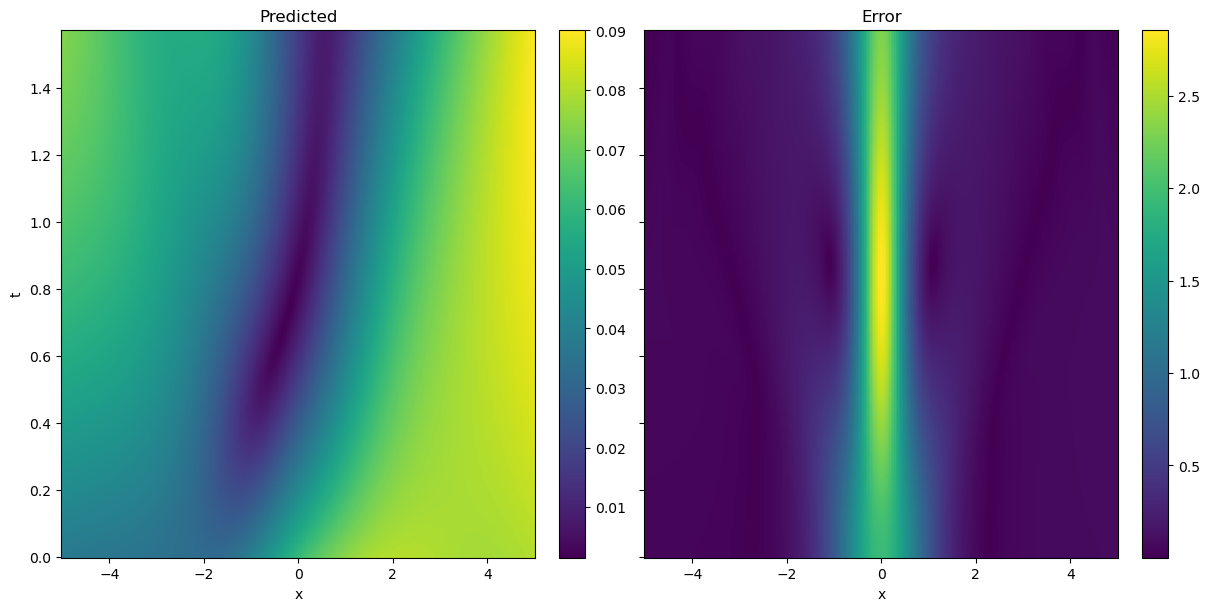

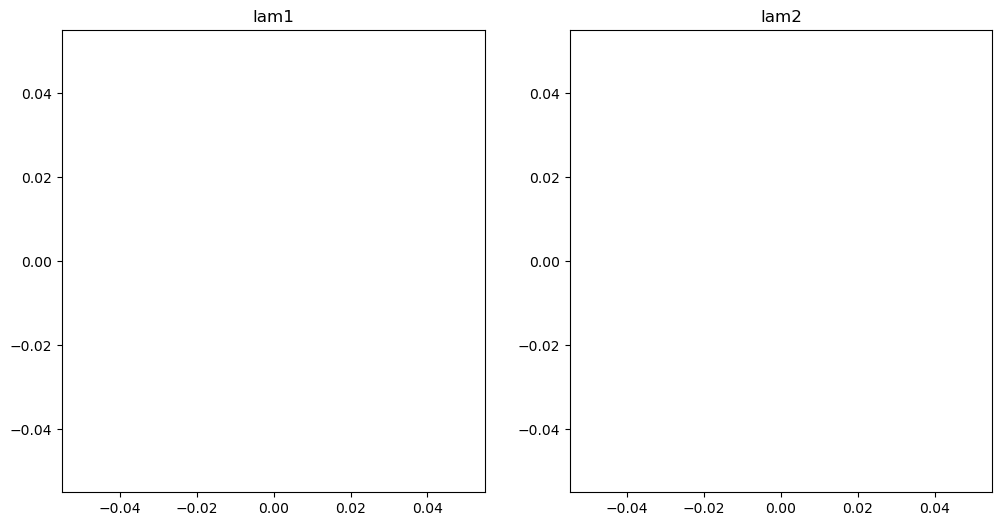

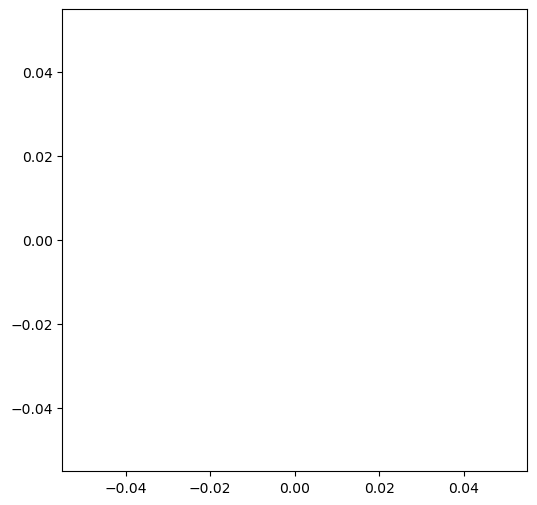

/usr/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [10500, 1], strides() = [1, 0]
param.sizes() = [10500, 1], strides() = [1, 0] (Triggered internally at /build/python-pytorch/src/pytorch-cuda/torch/csrc/autograd/functions/accumulate_grad.h:219.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step: 500, Loss: 0.39958304166793823
U data loss: 0.18640382587909698, U func loss: 0.007659503724426031
V data loss: 0.1888202577829361, V func loss: 0.016699450090527534
Lam1: 0.3178, lam2: 0.418
Step: 1000, Loss: 0.3909119963645935
U data loss: 0.1789119988679886, U func loss: 0.011412710882723331
V data loss: 0.18001657724380493, V func loss: 0.020570727065205574
Lam1: 0.3677, lam2: 0.3603
Step: 1500, Loss: 0.3813561797142029
U data loss: 0.17103168368339539, U func loss: 0.013392583467066288
V data loss: 0.17320621013641357, V func loss: 0.02372570149600506
Lam1: 0.3144, lam2: 0.3735
Step: 2000, Loss: 0.36910581588745117
U data loss: 0.15827739238739014, U func loss: 0.018156884238123894
V data loss: 0.1615460067987442, V func loss: 0.031125549226999283
Lam1: 0.1879, lam2: 0.4656
Step: 2500, Loss: 0.35707995295524597
U data loss: 0.1488138735294342, U func loss: 0.019278543069958687
V data loss: 0.1523730754852295, V func loss: 0.036614447832107544
Lam1: 0.0836, lam2: 0.5794
Step:

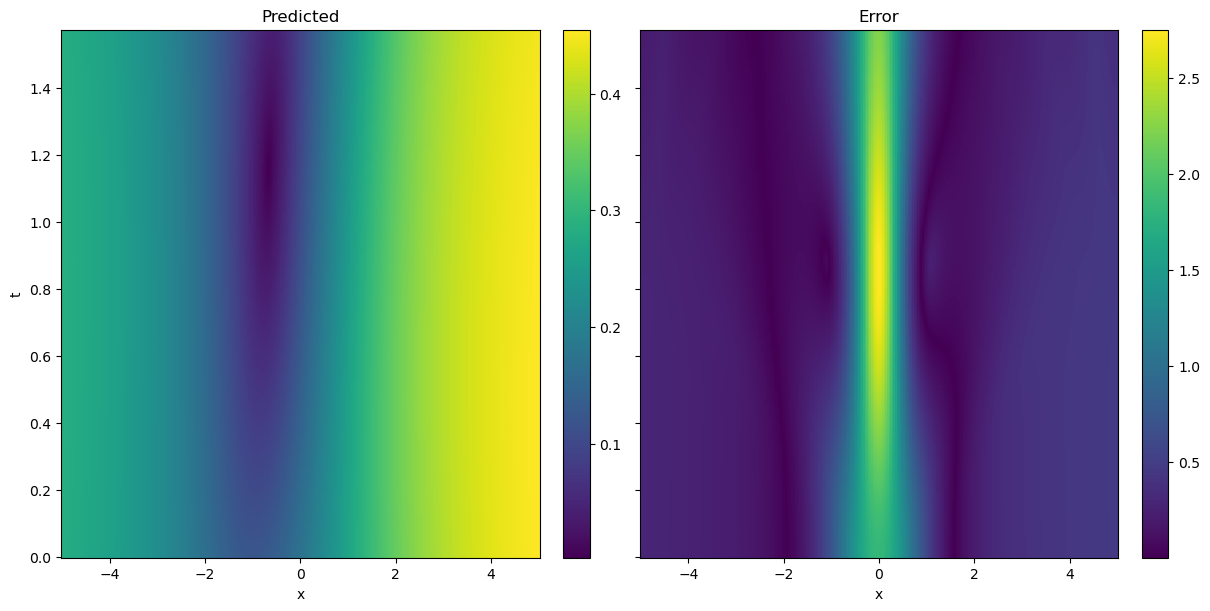

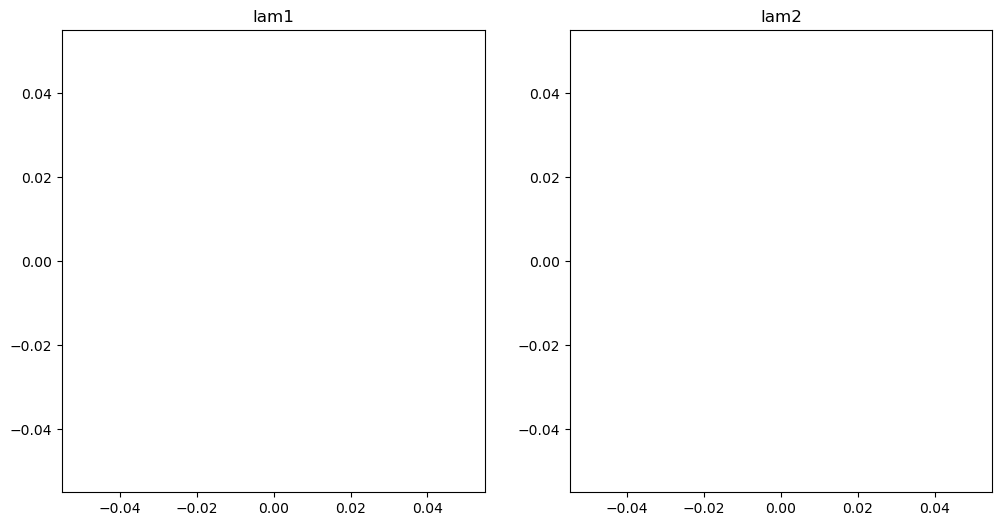

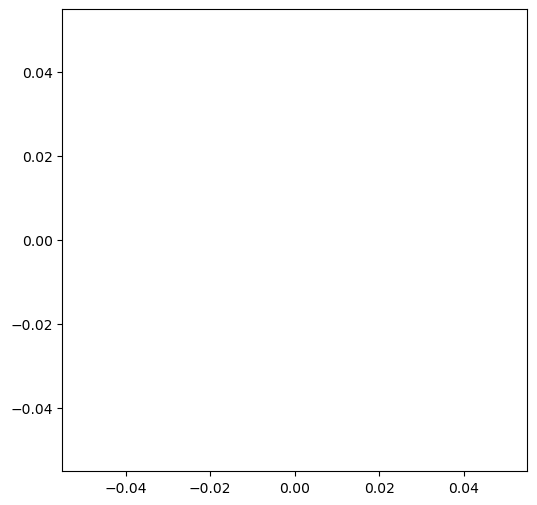

Step: 500, Loss: 0.3898305892944336
U data loss: 0.17549575865268707, U func loss: 0.011211470700800419
V data loss: 0.18440885841846466, V func loss: 0.018714483827352524
Lam1: 0.304, lam2: 0.4527
Step: 1000, Loss: 0.37361571192741394
U data loss: 0.15931949019432068, U func loss: 0.0175778865814209
V data loss: 0.1687500774860382, V func loss: 0.027968255802989006
Lam1: 0.2157, lam2: 0.4718
Step: 1500, Loss: 0.3565978407859802
U data loss: 0.15003596246242523, U func loss: 0.019705990329384804
V data loss: 0.15365125238895416, V func loss: 0.03320465609431267
Lam1: 0.1221, lam2: 0.5736
Step: 2000, Loss: 0.12354119122028351
U data loss: 0.05932198464870453, U func loss: 0.012869368307292461
V data loss: 0.03886448219418526, V func loss: 0.01248535979539156
Lam1: 0.2088, lam2: 0.7126
Step: 2500, Loss: 0.023598937317728996
U data loss: 0.011485258117318153, U func loss: 0.0030939634889364243
V data loss: 0.006197753828018904, V func loss: 0.0028219609521329403
Lam1: 0.2904, lam2: 0.7505

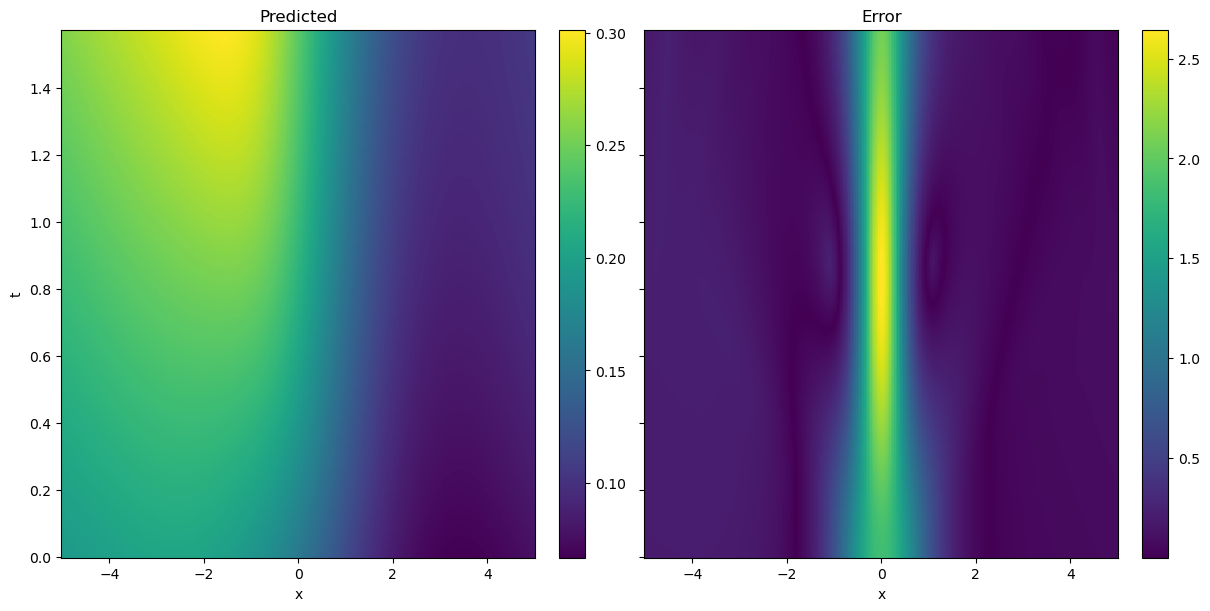

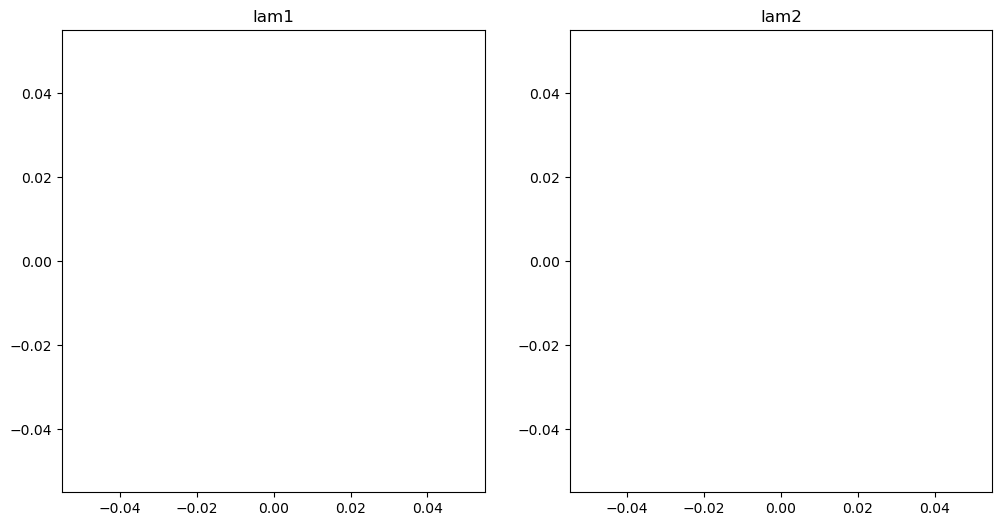

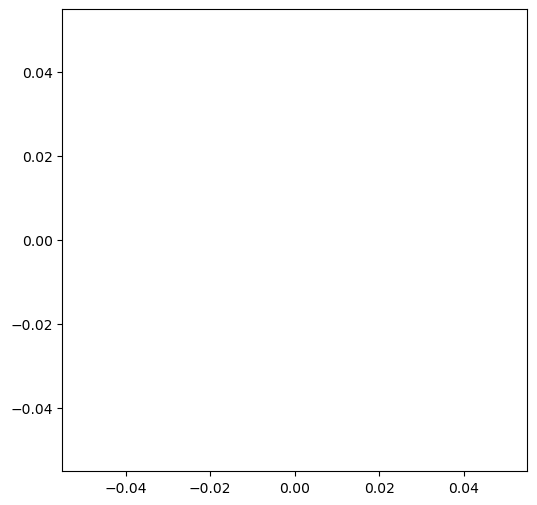

Step: 500, Loss: 0.3752434253692627
U data loss: 0.16409242153167725, U func loss: 0.015046598389744759
V data loss: 0.16914136707782745, V func loss: 0.026963064447045326
Lam1: 0.2194, lam2: 0.5015
Step: 1000, Loss: 0.34610515832901
U data loss: 0.13999740779399872, U func loss: 0.020622460171580315
V data loss: 0.1438826620578766, V func loss: 0.041602637618780136
Lam1: 0.1195, lam2: 0.6166
Step: 1500, Loss: 0.043851904571056366
U data loss: 0.021502627059817314, U func loss: 0.0040075937286019325
V data loss: 0.014225714839994907, V func loss: 0.0041159698739647865
Lam1: 0.2109, lam2: 0.6846
Step: 2000, Loss: 0.02377363294363022
U data loss: 0.011420348659157753, U func loss: 0.0019146938575431705
V data loss: 0.008268377743661404, V func loss: 0.002170214196667075
Lam1: 0.26, lam2: 0.6821
Step: 2500, Loss: 0.01619059406220913
U data loss: 0.007645668927580118, U func loss: 0.001375144231133163
V data loss: 0.005736487451940775, V func loss: 0.0014332938008010387
Lam1: 0.294, lam2: 

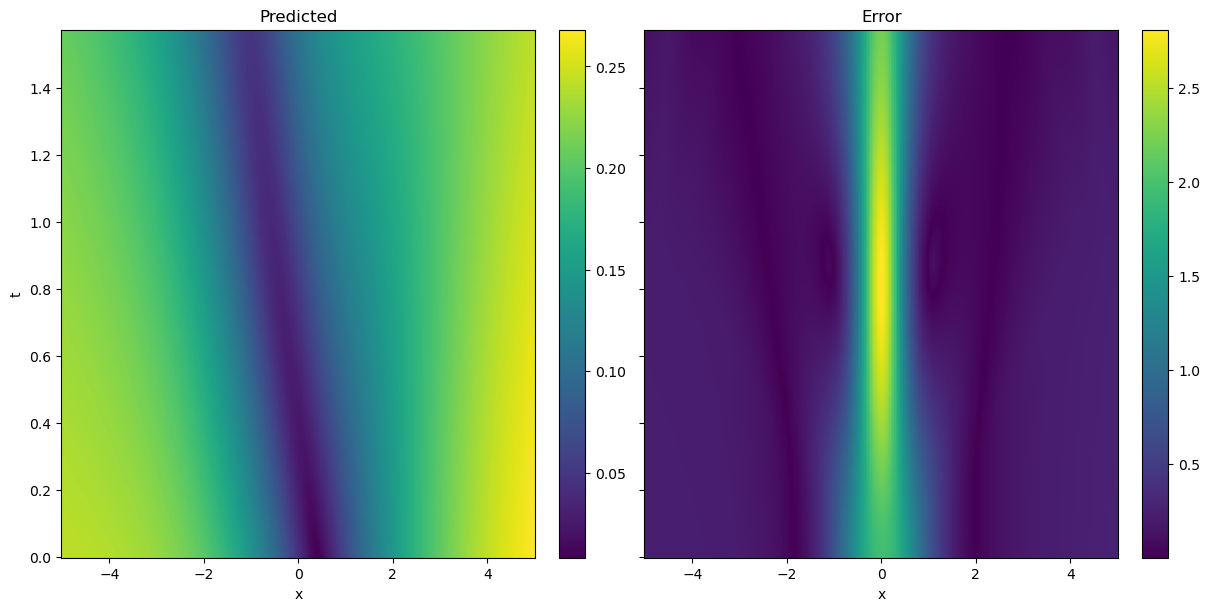

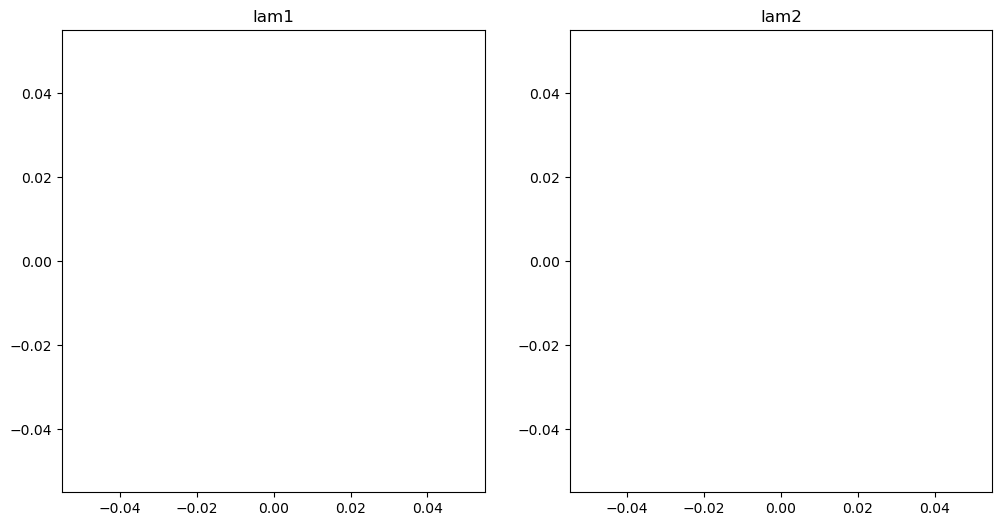

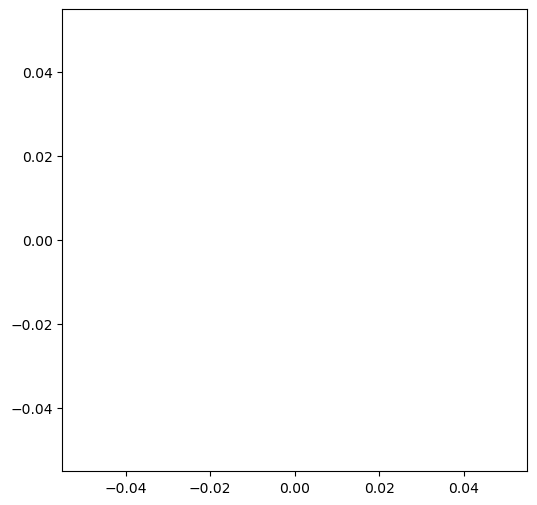

Step: 500, Loss: 0.35723111033439636
U data loss: 0.1529063582420349, U func loss: 0.0194083284586668
V data loss: 0.15198327600955963, V func loss: 0.03293316811323166
Lam1: 0.2072, lam2: 0.5337
Step: 1000, Loss: 0.03441103547811508
U data loss: 0.01604762114584446, U func loss: 0.004336423706263304
V data loss: 0.0089324451982975, V func loss: 0.0050945463590323925
Lam1: 0.2895, lam2: 0.6392
Step: 1500, Loss: 0.014553885906934738
U data loss: 0.007003817707300186, U func loss: 0.0015235249884426594
V data loss: 0.004405356012284756, V func loss: 0.0016211869660764933
Lam1: 0.3346, lam2: 0.6718
Step: 2000, Loss: 0.014352064579725266
U data loss: 0.004653585143387318, U func loss: 0.0015081212623044848
V data loss: 0.0034546267706900835, V func loss: 0.004735731519758701
Lam1: 0.3613, lam2: 0.7
Step: 2500, Loss: 0.00748091796413064
U data loss: 0.0034540491178631783, U func loss: 0.0006608355324715376
V data loss: 0.0027258782647550106, V func loss: 0.0006401551072485745
Lam1: 0.3806, 

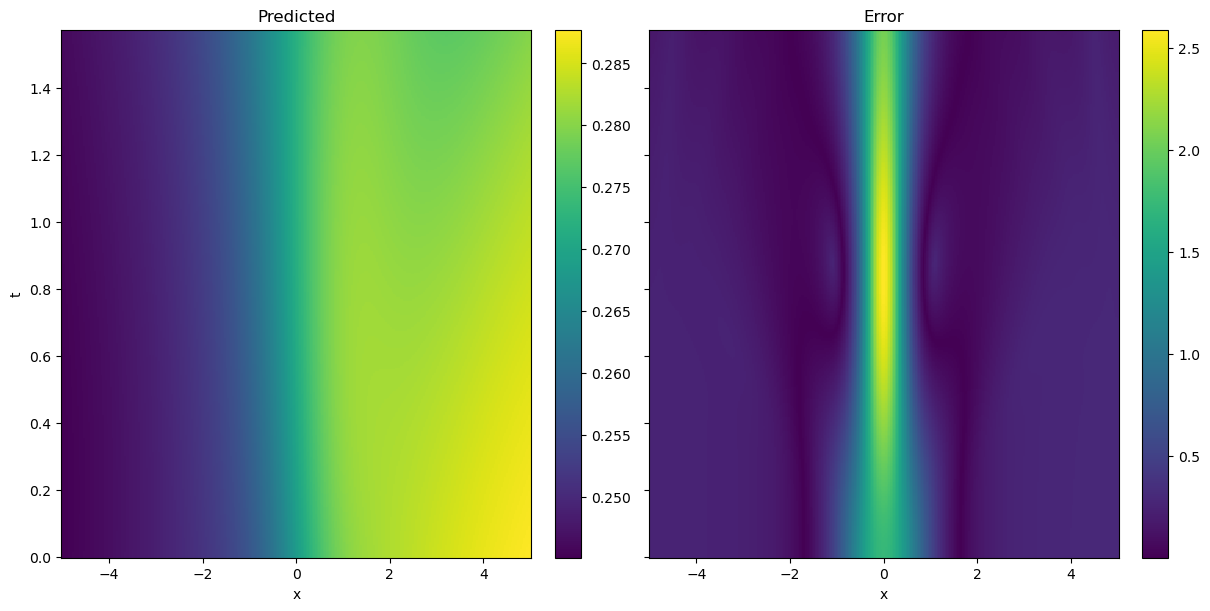

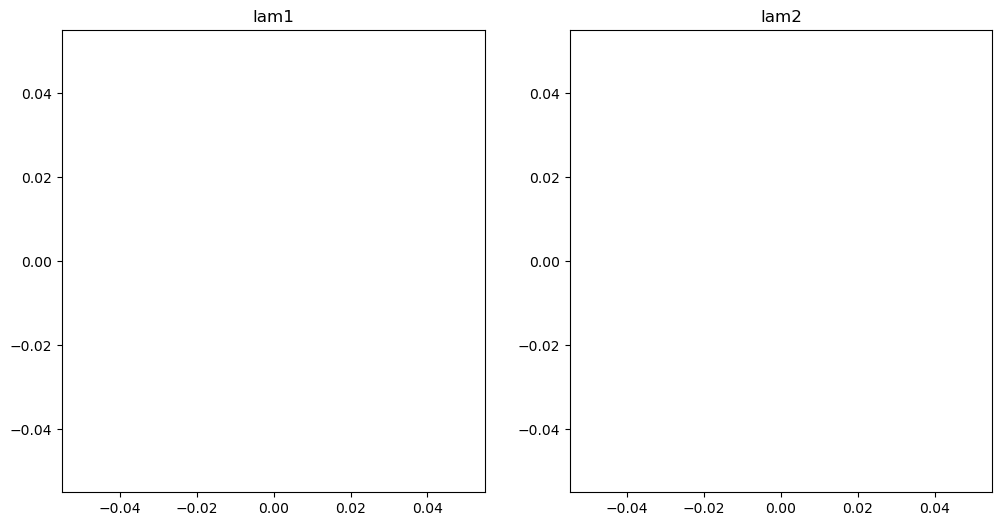

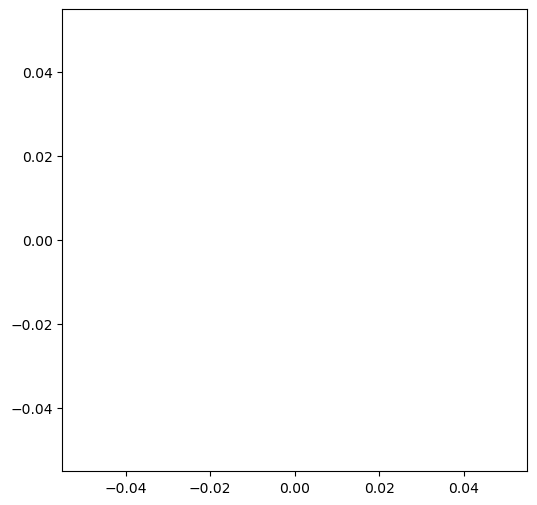

Step: 500, Loss: 0.39563149213790894
U data loss: 0.18159179389476776, U func loss: 0.010741856880486012
V data loss: 0.18324367702007294, V func loss: 0.02005416341125965
Lam1: 0.2393, lam2: 0.4407
Step: 1000, Loss: 0.368770569562912
U data loss: 0.15750156342983246, U func loss: 0.019346222281455994
V data loss: 0.16109418869018555, V func loss: 0.03082856722176075
Lam1: 0.1753, lam2: 0.4389
Step: 1500, Loss: 0.23877787590026855
U data loss: 0.11326166987419128, U func loss: 0.014405866153538227
V data loss: 0.09047611057758331, V func loss: 0.020634226500988007
Lam1: 0.0891, lam2: 0.5884
Step: 2000, Loss: 0.060175102204084396
U data loss: 0.022518424317240715, U func loss: 0.009458278305828571
V data loss: 0.01729615032672882, V func loss: 0.01090224925428629
Lam1: 0.1867, lam2: 0.6473
Step: 2500, Loss: 0.026047514751553535
U data loss: 0.01069636456668377, U func loss: 0.003067177953198552
V data loss: 0.00899513904005289, V func loss: 0.003288832027465105
Lam1: 0.2356, lam2: 0.652

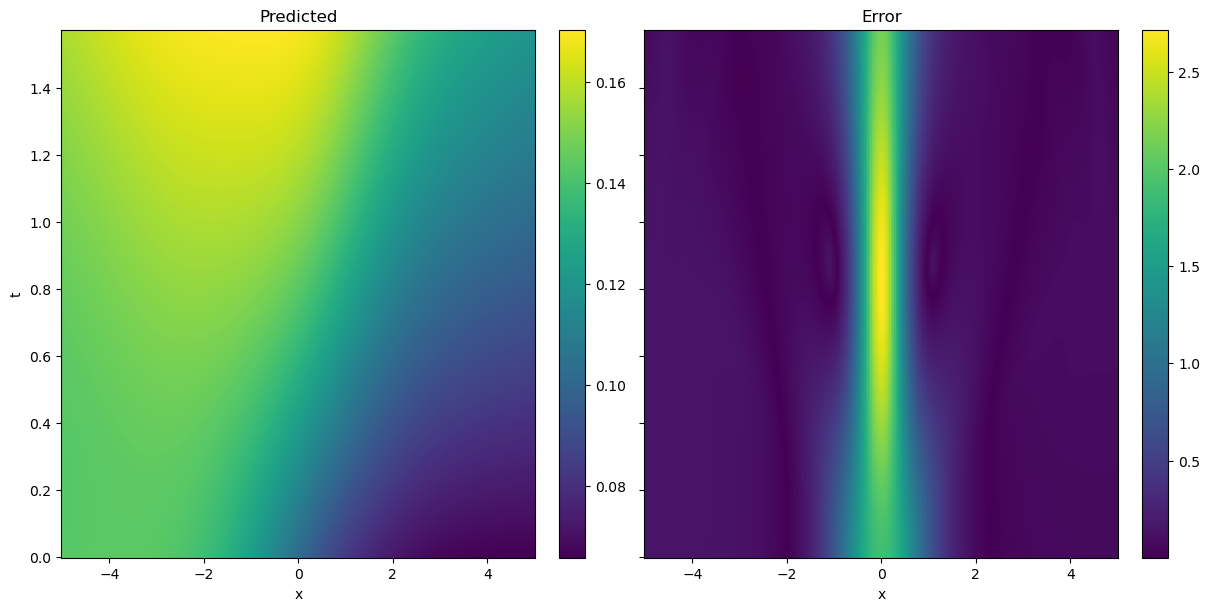

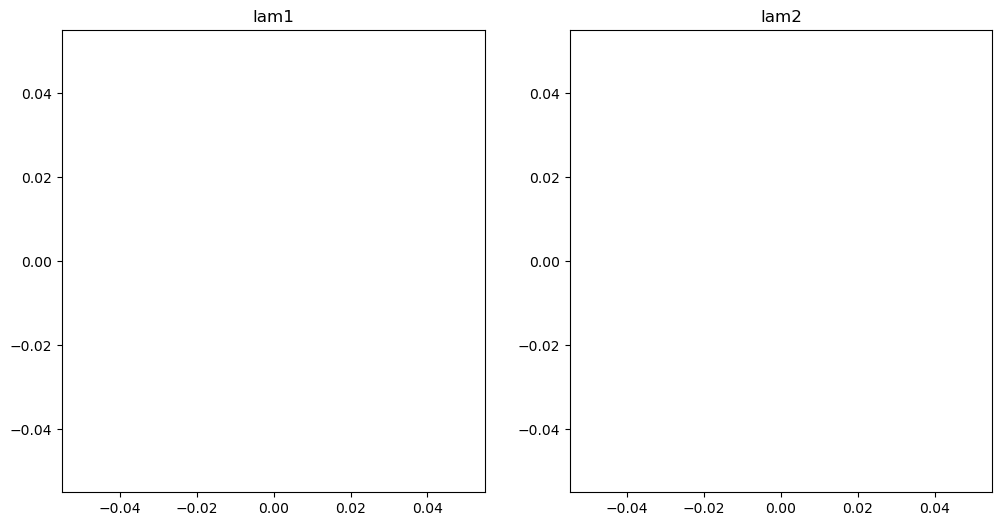

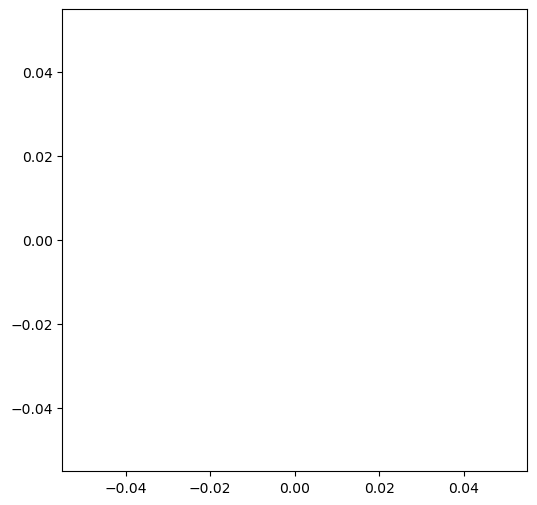

Step: 500, Loss: 0.3785536289215088
U data loss: 0.16648325324058533, U func loss: 0.015996843576431274
V data loss: 0.17062528431415558, V func loss: 0.02544822171330452
Lam1: 0.2802, lam2: 0.4614
Step: 1000, Loss: 0.3511538505554199
U data loss: 0.14612369239330292, U func loss: 0.020928725600242615
V data loss: 0.1472979038953781, V func loss: 0.036803554743528366
Lam1: 0.1684, lam2: 0.5556
Step: 1500, Loss: 0.03400909900665283
U data loss: 0.016156066209077835, U func loss: 0.0034867229405790567
V data loss: 0.010427376255393028, V func loss: 0.0039389352314174175
Lam1: 0.2618, lam2: 0.6506
Step: 2000, Loss: 0.017011858522892
U data loss: 0.00780405243858695, U func loss: 0.0018932581879198551
V data loss: 0.0056887539103627205, V func loss: 0.0016257943352684379
Lam1: 0.3113, lam2: 0.68
Step: 2500, Loss: 0.011835259385406971
U data loss: 0.005268126726150513, U func loss: 0.001436386490240693
V data loss: 0.0041013117879629135, V func loss: 0.0010294342646375299
Lam1: 0.3437, lam2

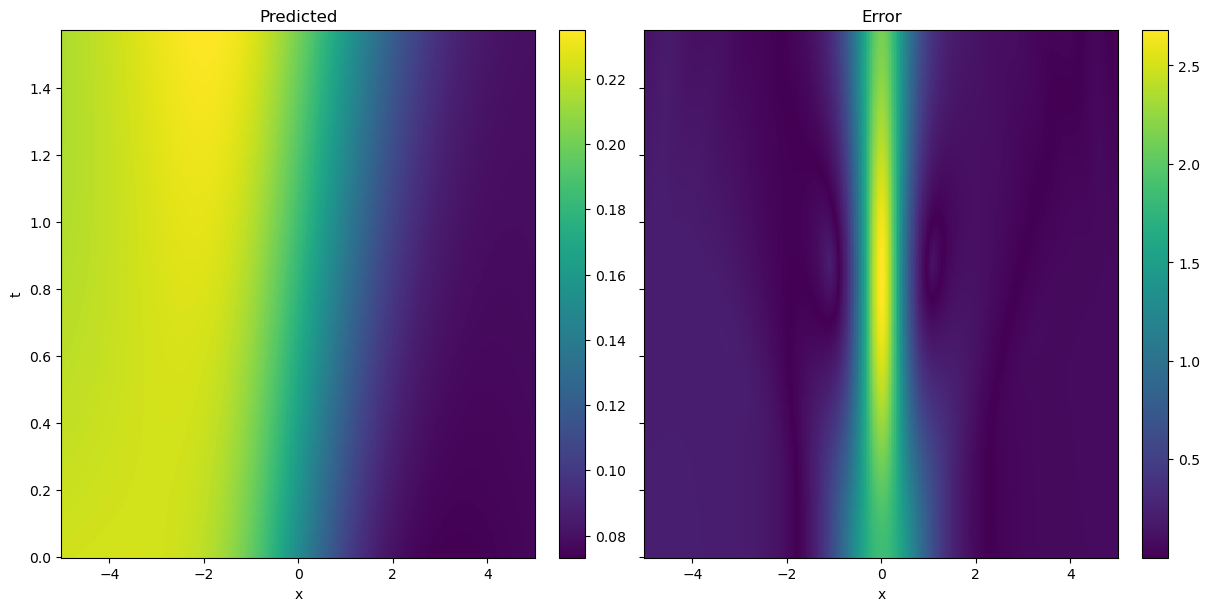

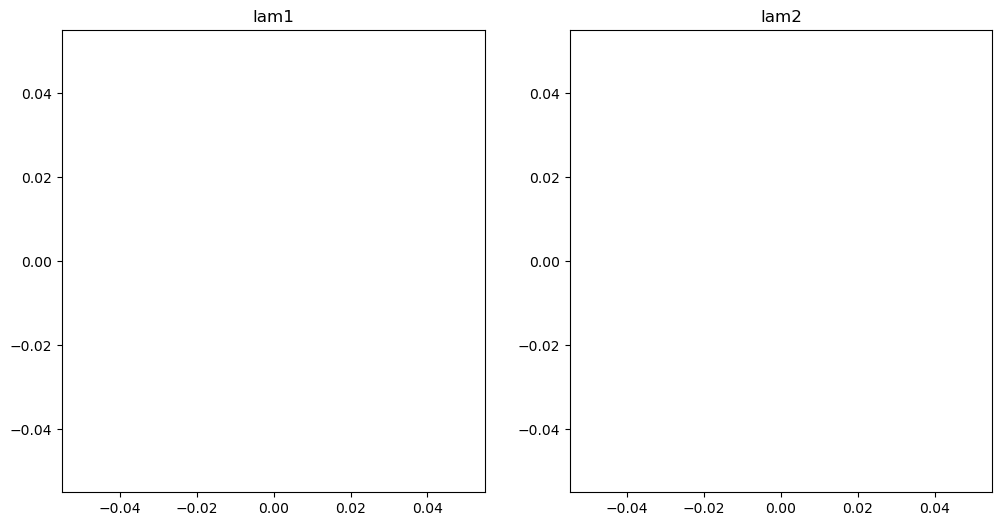

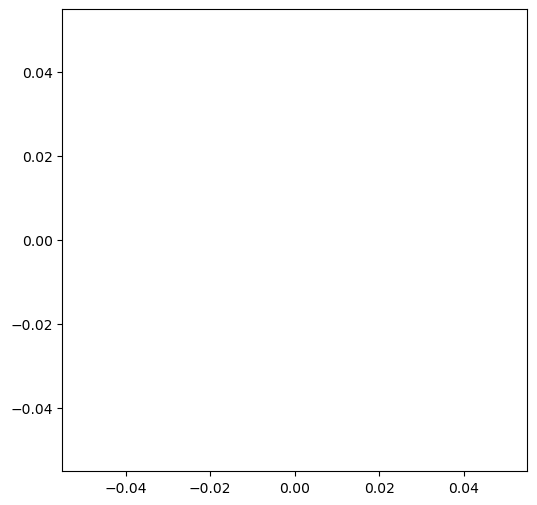

Step: 500, Loss: 0.36554425954818726
U data loss: 0.154532790184021, U func loss: 0.019528387114405632
V data loss: 0.15808305144309998, V func loss: 0.0334000401198864
Lam1: 0.2042, lam2: 0.5241
Step: 1000, Loss: 0.05105839669704437
U data loss: 0.021608702838420868, U func loss: 0.006524859461933374
V data loss: 0.015139942057430744, V func loss: 0.007784891873598099
Lam1: 0.2604, lam2: 0.6312
Step: 1500, Loss: 0.022183343768119812
U data loss: 0.009135711006820202, U func loss: 0.0032463683746755123
V data loss: 0.006122353486716747, V func loss: 0.003678910667076707
Lam1: 0.3107, lam2: 0.6637
Step: 2000, Loss: 0.014619153924286366
U data loss: 0.006181341130286455, U func loss: 0.0019303254084661603
V data loss: 0.004400280769914389, V func loss: 0.0021072067320346832
Lam1: 0.3416, lam2: 0.6889
Step: 2500, Loss: 0.011388001963496208
U data loss: 0.004687016364187002, U func loss: 0.0015627528773620725
V data loss: 0.003558951197192073, V func loss: 0.0015792817575857043
Lam1: 0.363

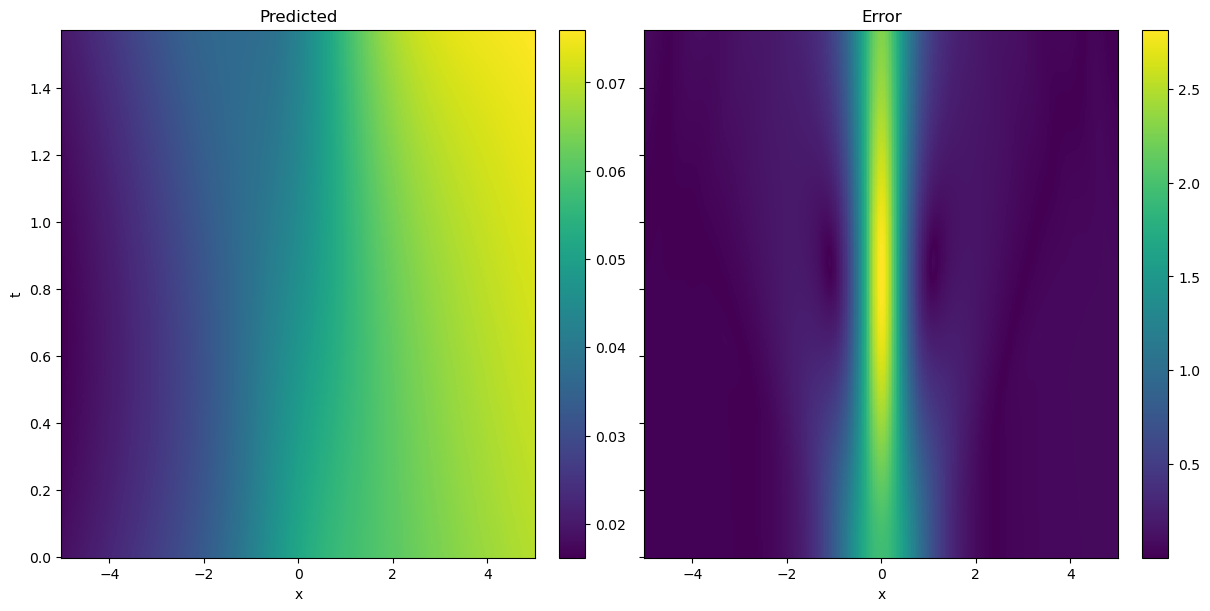

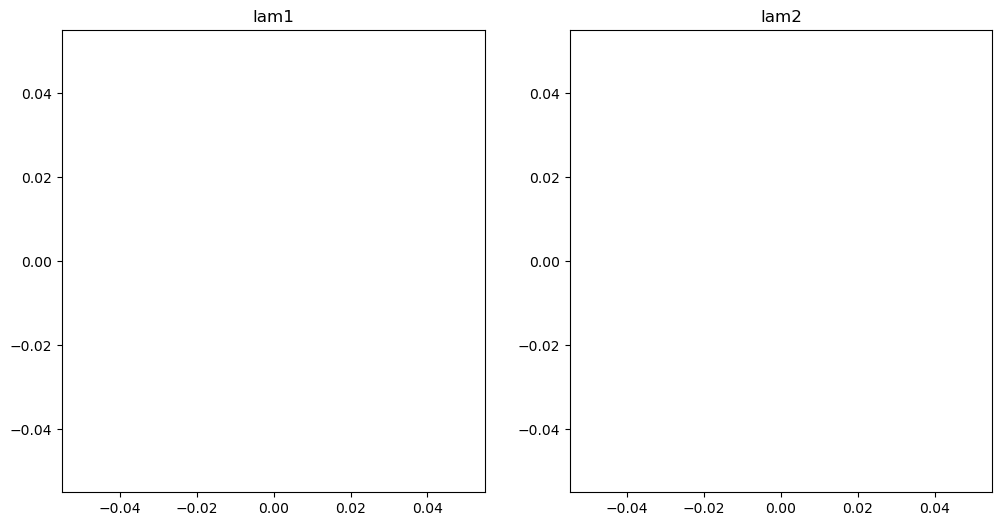

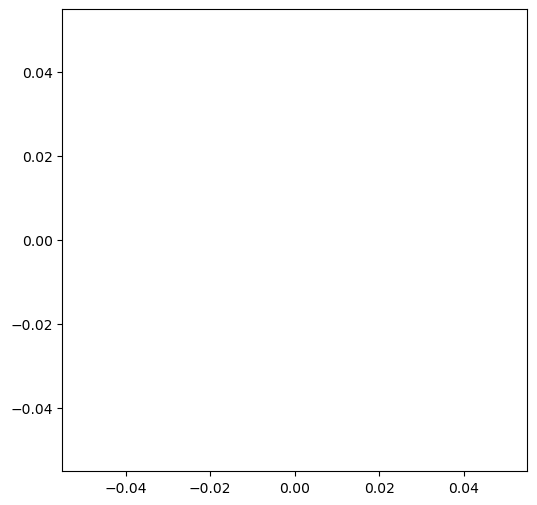

Step: 500, Loss: 0.17418888211250305
U data loss: 0.08826777338981628, U func loss: 0.010917368344962597
V data loss: 0.0618179589509964, V func loss: 0.013185782358050346
Lam1: 0.233, lam2: 0.5629
Step: 1000, Loss: 0.030067291110754013
U data loss: 0.013647552579641342, U func loss: 0.00430208258330822
V data loss: 0.008680537343025208, V func loss: 0.0034371186047792435
Lam1: 0.2979, lam2: 0.6261
Step: 1500, Loss: 0.023010069504380226
U data loss: 0.008767504245042801, U func loss: 0.004315690603107214
V data loss: 0.005401027854532003, V func loss: 0.0045258463360369205
Lam1: 0.3298, lam2: 0.6512
Step: 2000, Loss: 0.014127462171018124
U data loss: 0.006384334061294794, U func loss: 0.0019867459777742624
V data loss: 0.004409178160130978, V func loss: 0.0013472040882334113
Lam1: 0.3516, lam2: 0.6733
Step: 2500, Loss: 0.01300638448446989
U data loss: 0.0051872748881578445, U func loss: 0.0023546277079731226
V data loss: 0.003925925120711327, V func loss: 0.001538557349704206
Lam1: 0.3

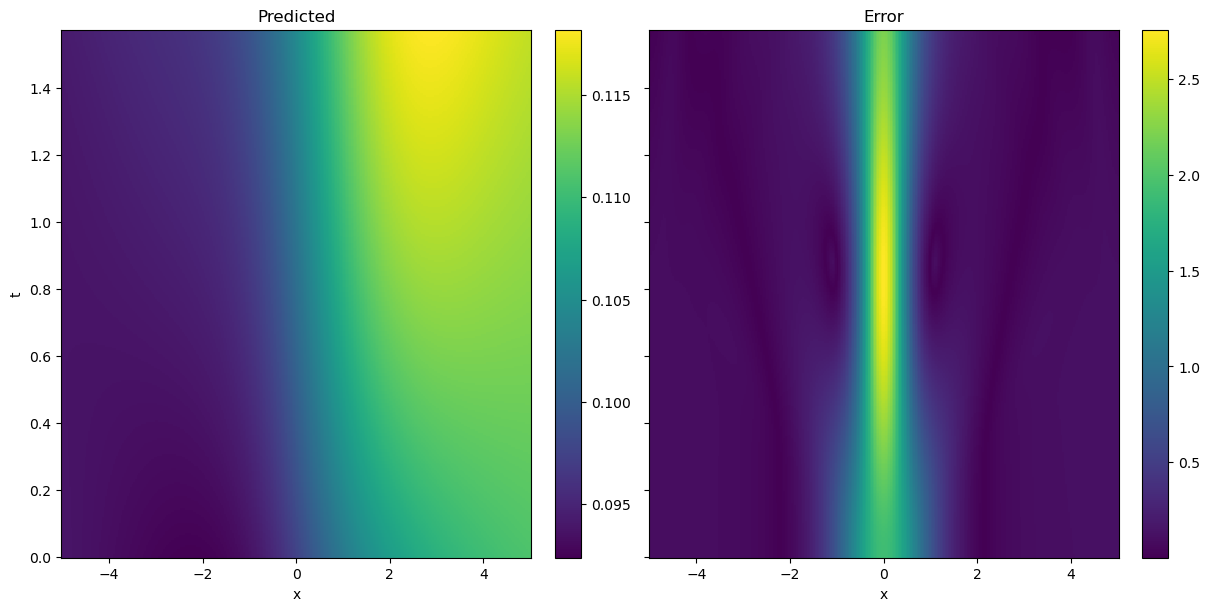

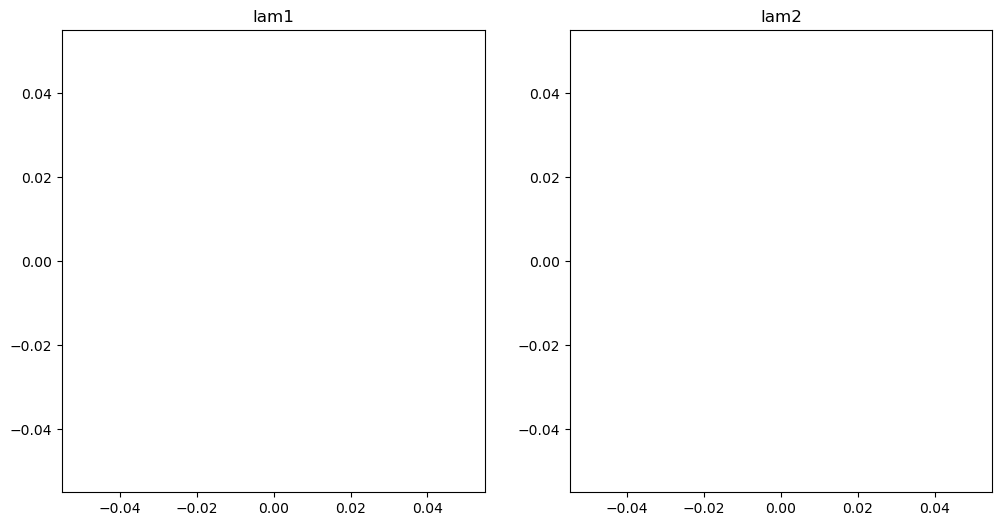

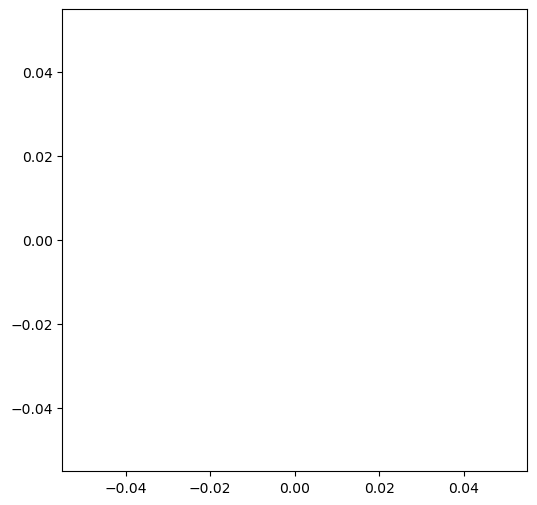

Step: 500, Loss: 0.3896835744380951
U data loss: 0.17677141726016998, U func loss: 0.012484448961913586
V data loss: 0.17917656898498535, V func loss: 0.02125113271176815
Lam1: 0.3204, lam2: 0.415
Step: 1000, Loss: 0.3623362183570862
U data loss: 0.1535281538963318, U func loss: 0.020674025639891624
V data loss: 0.15447869896888733, V func loss: 0.03365533426403999
Lam1: 0.1959, lam2: 0.4693
Step: 1500, Loss: 0.09211086481809616
U data loss: 0.03860354423522949, U func loss: 0.013069655746221542
V data loss: 0.02661977894604206, V func loss: 0.013817882165312767
Lam1: 0.2601, lam2: 0.5812
Step: 2000, Loss: 0.03471865877509117
U data loss: 0.01268930733203888, U func loss: 0.005802432540804148
V data loss: 0.008631824515759945, V func loss: 0.007595093455165625
Lam1: 0.3061, lam2: 0.6457
Step: 2500, Loss: 0.02069578319787979
U data loss: 0.007669039070606232, U func loss: 0.004078214522451162
V data loss: 0.005153578706085682, V func loss: 0.0037949513643980026
Lam1: 0.3438, lam2: 0.687

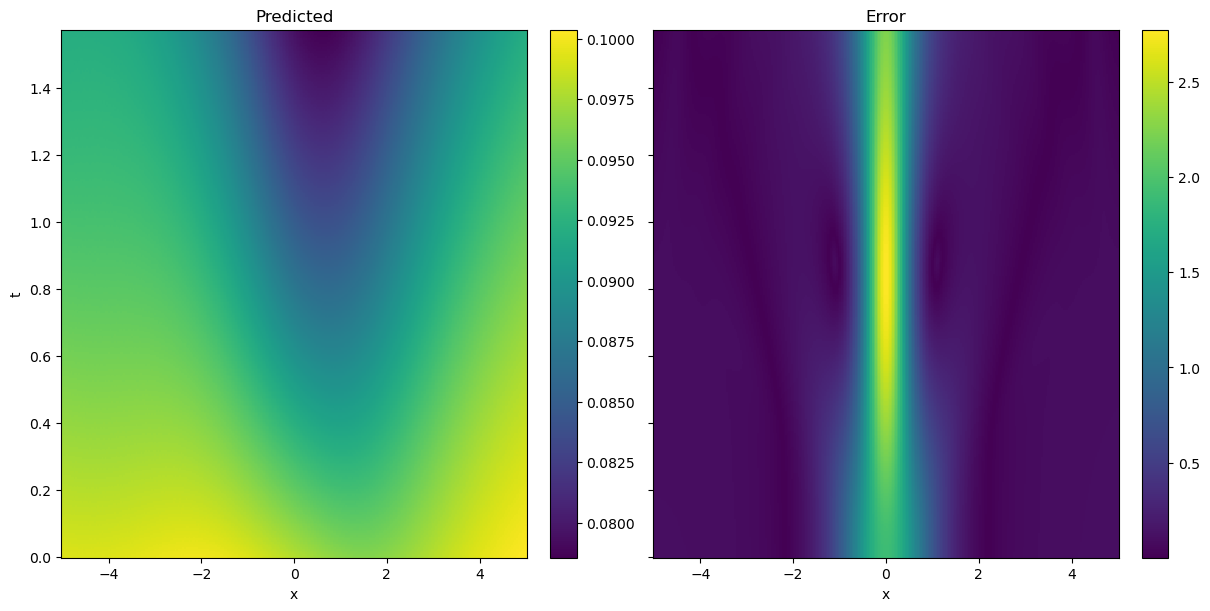

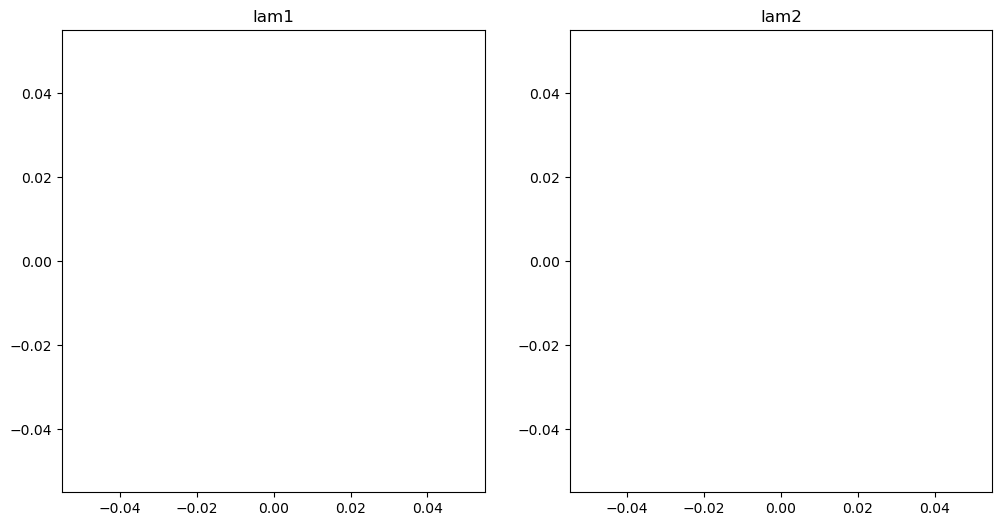

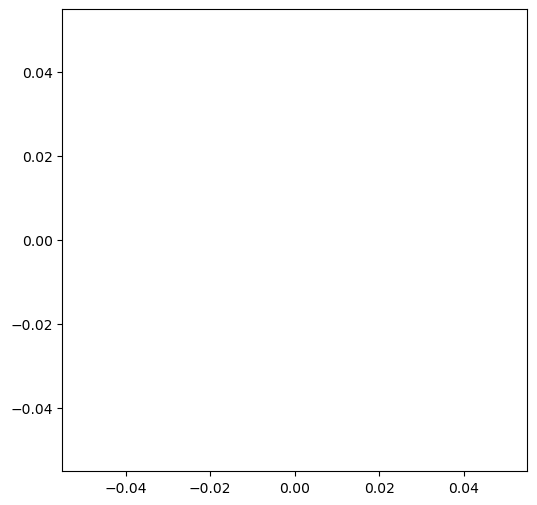

Step: 500, Loss: 0.3699033558368683
U data loss: 0.1581674963235855, U func loss: 0.018397893756628036
V data loss: 0.16093622148036957, V func loss: 0.03240174055099487
Lam1: 0.2412, lam2: 0.4813
Step: 1000, Loss: 0.0885799303650856
U data loss: 0.040593307465314865, U func loss: 0.00857964064925909
V data loss: 0.02652045525610447, V func loss: 0.012886524200439453
Lam1: 0.2457, lam2: 0.5956
Step: 1500, Loss: 0.02692105993628502
U data loss: 0.01089454349130392, U func loss: 0.004271106794476509
V data loss: 0.008051387034356594, V func loss: 0.0037040223833173513
Lam1: 0.3035, lam2: 0.6366
Step: 2000, Loss: 0.018533749505877495
U data loss: 0.007374665699899197, U func loss: 0.002650883747264743
V data loss: 0.006070404779165983, V func loss: 0.002437795978039503
Lam1: 0.3343, lam2: 0.6649
Step: 2500, Loss: 0.014530302956700325
U data loss: 0.005681819282472134, U func loss: 0.0022257142700254917
V data loss: 0.004866900388151407, V func loss: 0.0017558690160512924
Lam1: 0.3573, lam

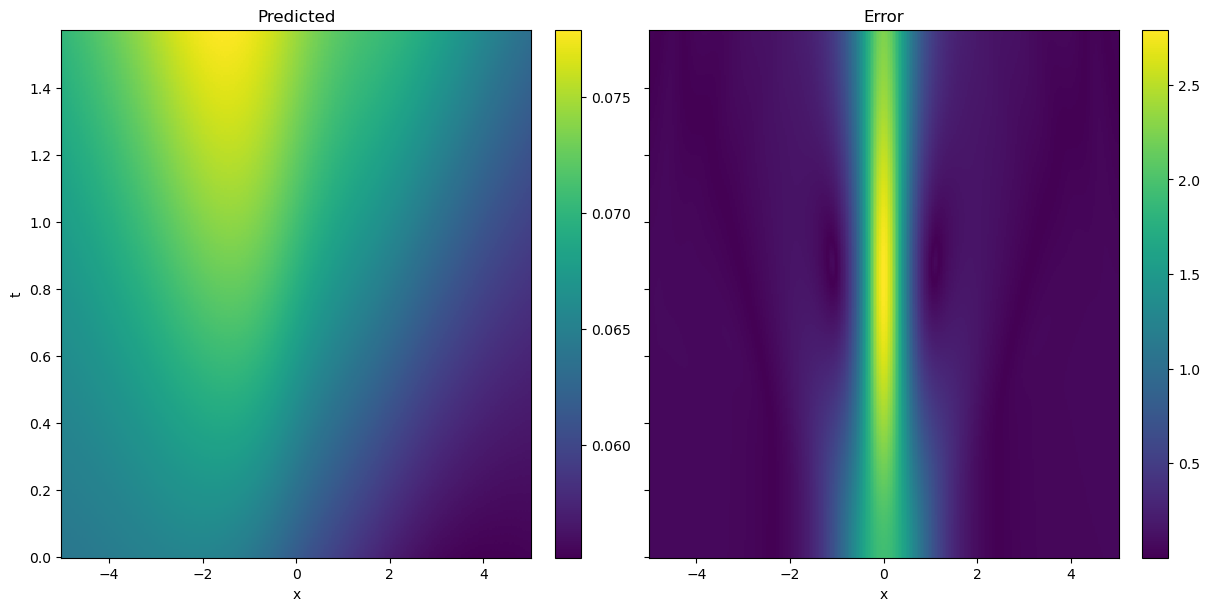

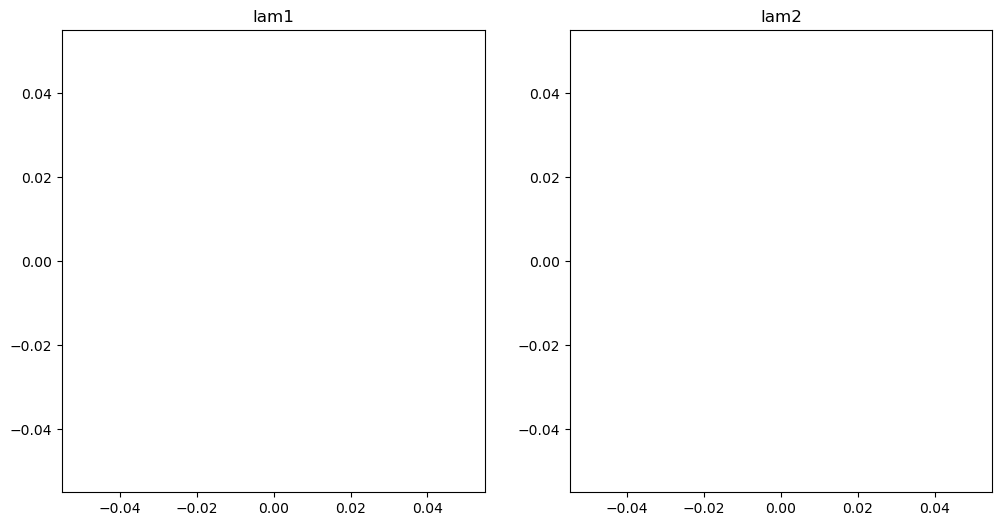

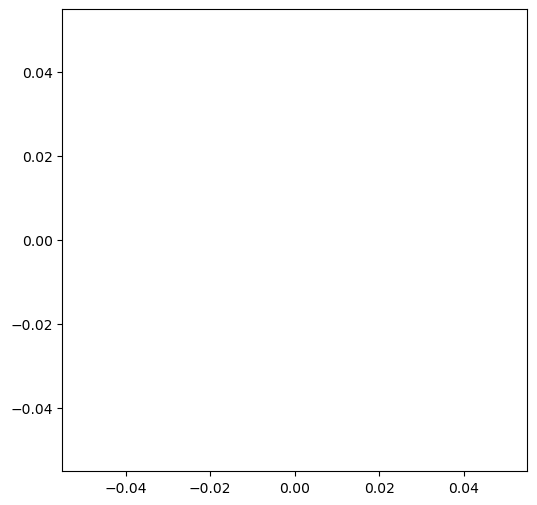

Step: 500, Loss: 0.13667796552181244
U data loss: 0.06644923239946365, U func loss: 0.008827525191009045
V data loss: 0.04816697537899017, V func loss: 0.013234229758381844
Lam1: 0.2565, lam2: 0.5374
Step: 1000, Loss: 0.03632529452443123
U data loss: 0.014023763127624989, U func loss: 0.006210398860275745
V data loss: 0.009469150565564632, V func loss: 0.0066219838336110115
Lam1: 0.3119, lam2: 0.6031
Step: 1500, Loss: 0.019535690546035767
U data loss: 0.008155373856425285, U func loss: 0.0029599478002637625
V data loss: 0.005670095328241587, V func loss: 0.002750273095443845
Lam1: 0.3407, lam2: 0.6381
Step: 2000, Loss: 0.01651175320148468
U data loss: 0.006198648829013109, U func loss: 0.0035524647682905197
V data loss: 0.0044248164631426334, V func loss: 0.0023358226753771305
Lam1: 0.3612, lam2: 0.6667
Step: 2500, Loss: 0.014725119806826115
U data loss: 0.004852963611483574, U func loss: 0.0022435681894421577
V data loss: 0.003720124252140522, V func loss: 0.003908463753759861
Lam1: 0

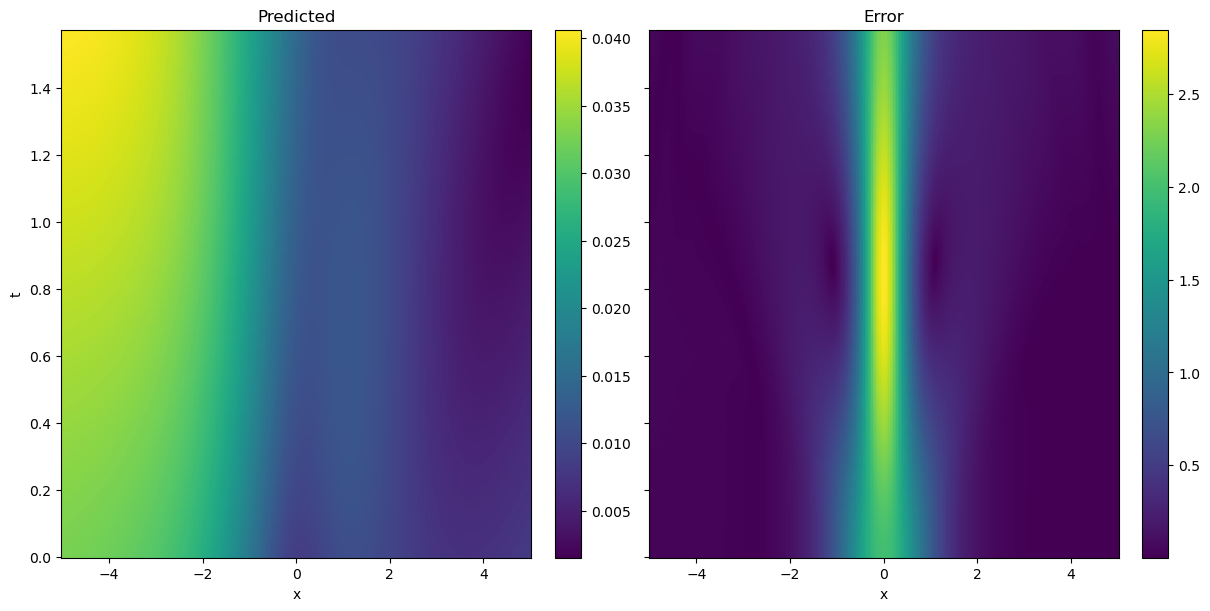

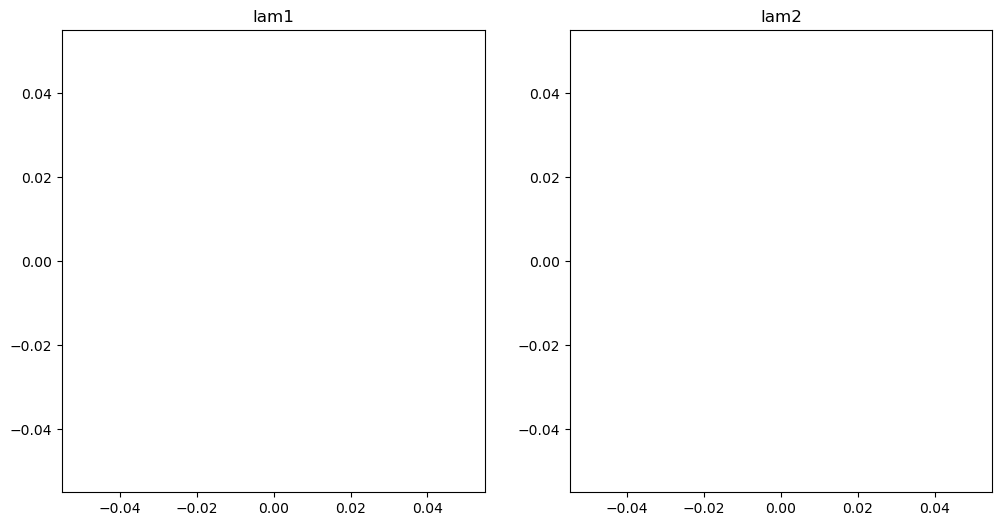

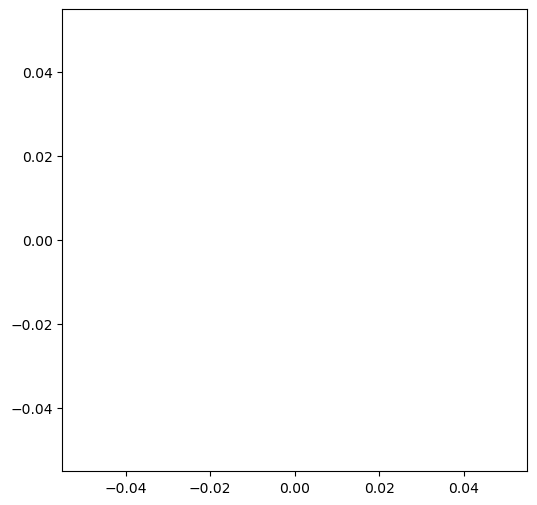

Step: 500, Loss: 0.10263526439666748
U data loss: 0.048438459634780884, U func loss: 0.010534386150538921
V data loss: 0.0332440584897995, V func loss: 0.010418363846838474
Lam1: 0.2726, lam2: 0.5605
Step: 1000, Loss: 0.04015280678868294
U data loss: 0.01602446474134922, U func loss: 0.0071669383905828
V data loss: 0.010341939516365528, V func loss: 0.006619465537369251
Lam1: 0.3091, lam2: 0.6003
Step: 1500, Loss: 0.0226131621748209
U data loss: 0.009507710114121437, U func loss: 0.0032473753672093153
V data loss: 0.006931459531188011, V func loss: 0.0029266183264553547
Lam1: 0.3308, lam2: 0.6291
Step: 2000, Loss: 0.016965702176094055
U data loss: 0.007134892512112856, U func loss: 0.002482099924236536
V data loss: 0.00531358364969492, V func loss: 0.002035125158727169
Lam1: 0.347, lam2: 0.6533
Step: 2500, Loss: 0.013703599572181702
U data loss: 0.005904094781726599, U func loss: 0.0019535336177796125
V data loss: 0.004415816627442837, V func loss: 0.00143015431240201
Lam1: 0.3612, lam

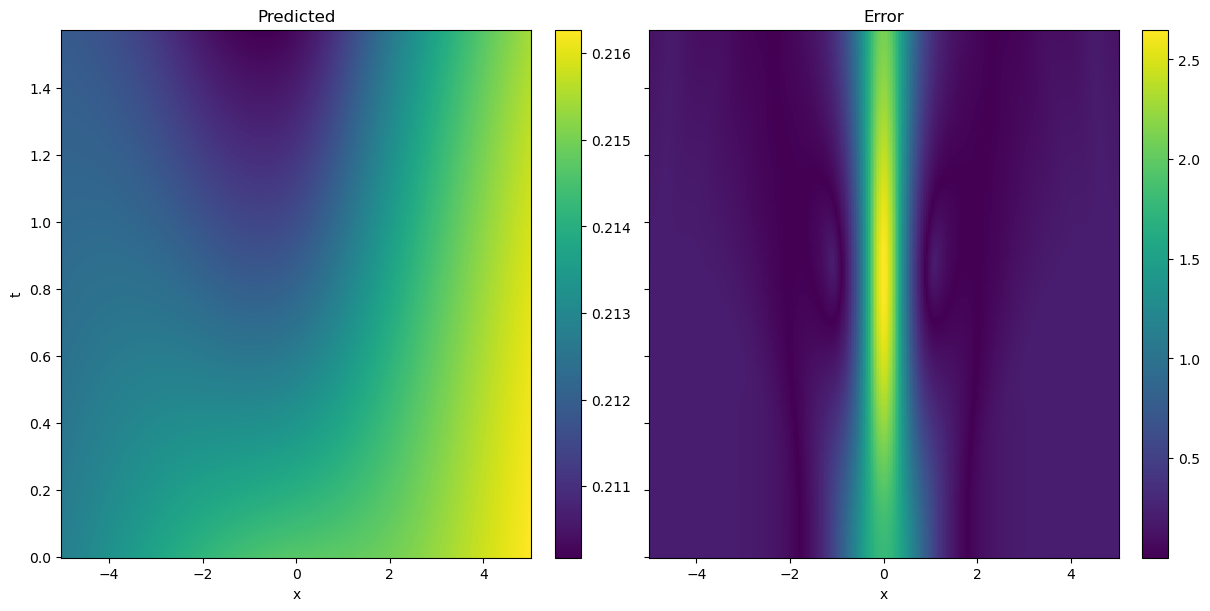

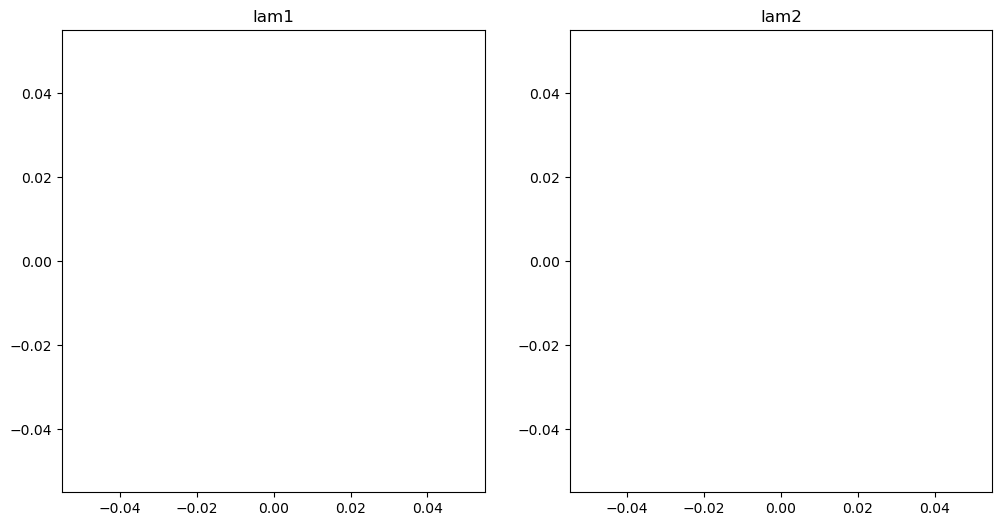

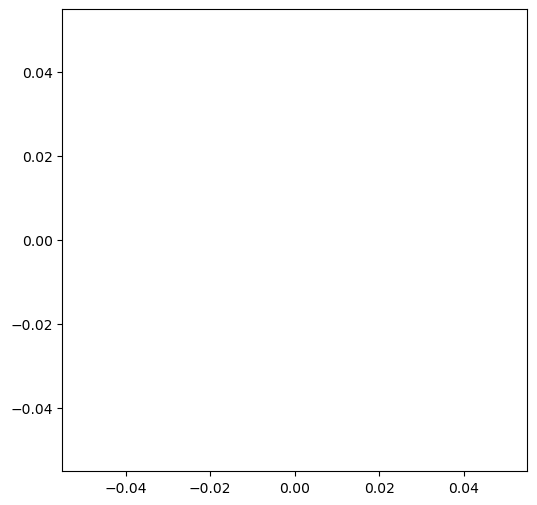

Step: 500, Loss: 0.38906556367874146
U data loss: 0.1767137050628662, U func loss: 0.012532074935734272
V data loss: 0.17618407309055328, V func loss: 0.02363571897149086
Lam1: 0.2739, lam2: 0.4244
Step: 1000, Loss: 0.17360661923885345
U data loss: 0.08441784232854843, U func loss: 0.011026443913578987
V data loss: 0.06014327332377434, V func loss: 0.018019067123532295
Lam1: 0.2073, lam2: 0.5264
Step: 1500, Loss: 0.07460242509841919
U data loss: 0.03614577651023865, U func loss: 0.007235084194689989
V data loss: 0.023906998336315155, V func loss: 0.007314566522836685
Lam1: 0.2839, lam2: 0.5525
Step: 2000, Loss: 0.04325488209724426
U data loss: 0.01876481994986534, U func loss: 0.006449799984693527
V data loss: 0.012472560629248619, V func loss: 0.005567700136452913
Lam1: 0.327, lam2: 0.5916
Step: 2500, Loss: 0.028105907142162323
U data loss: 0.01140954252332449, U func loss: 0.004331469535827637
V data loss: 0.007889182306826115, V func loss: 0.004475713707506657
Lam1: 0.3567, lam2: 0.

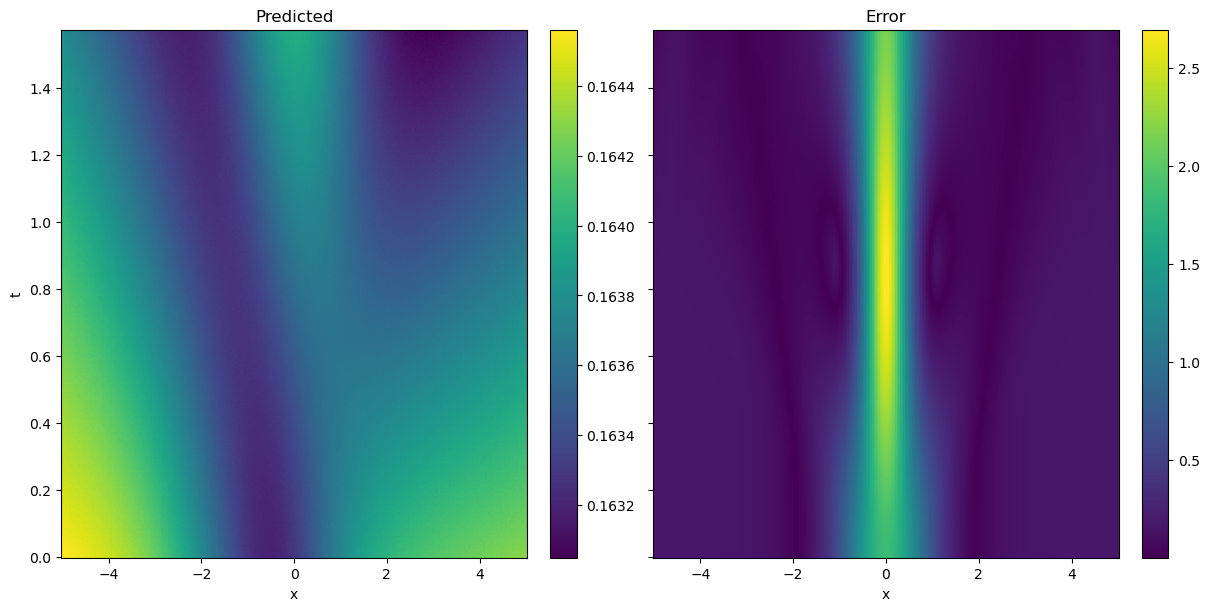

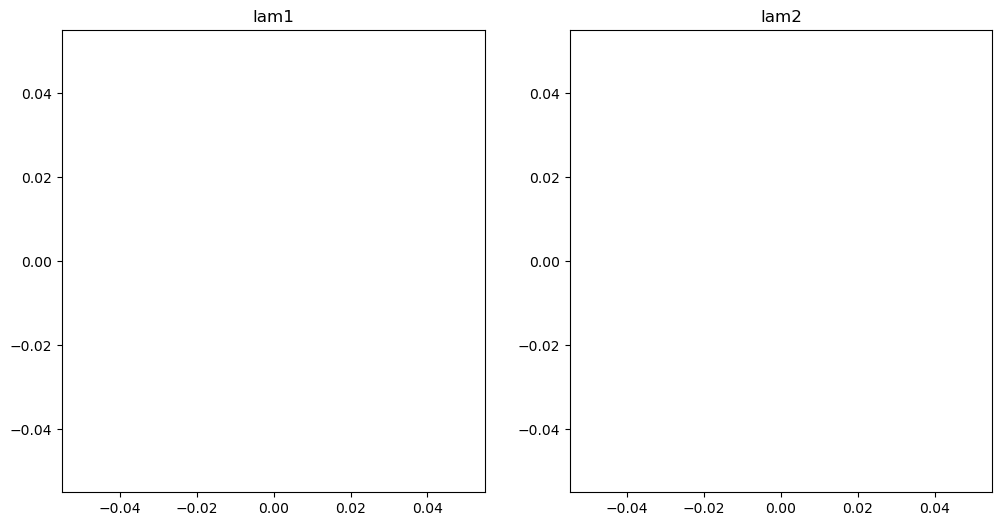

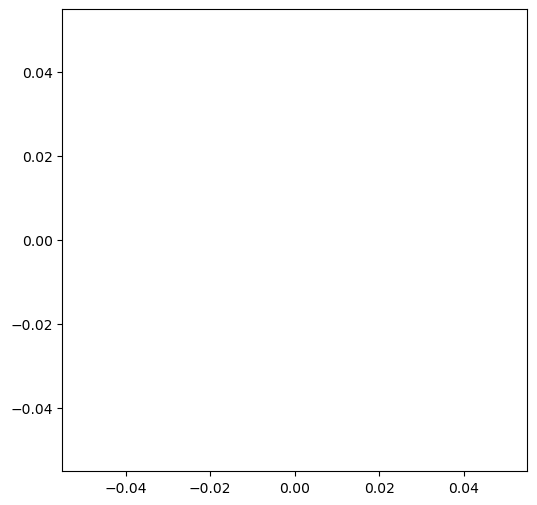

Step: 500, Loss: 0.3673342764377594
U data loss: 0.15593601763248444, U func loss: 0.01943732239305973
V data loss: 0.15905378758907318, V func loss: 0.0329071506857872
Lam1: 0.2275, lam2: 0.4769
Step: 1000, Loss: 0.08171219378709793
U data loss: 0.036091431975364685, U func loss: 0.010569991543889046
V data loss: 0.023980893194675446, V func loss: 0.011069878935813904
Lam1: 0.2732, lam2: 0.5624
Step: 1500, Loss: 0.03803429752588272
U data loss: 0.014295096509158611, U func loss: 0.006750352215021849
V data loss: 0.009470410645008087, V func loss: 0.00751843536272645
Lam1: 0.317, lam2: 0.6028
Step: 2000, Loss: 0.024248365312814713
U data loss: 0.008674368262290955, U func loss: 0.004425721243023872
V data loss: 0.007312254514545202, V func loss: 0.0038360205944627523
Lam1: 0.3463, lam2: 0.6291
Step: 2500, Loss: 0.020108213648200035
U data loss: 0.006793664768338203, U func loss: 0.003939848393201828
V data loss: 0.005997180473059416, V func loss: 0.0033775190822780132
Lam1: 0.3695, lam

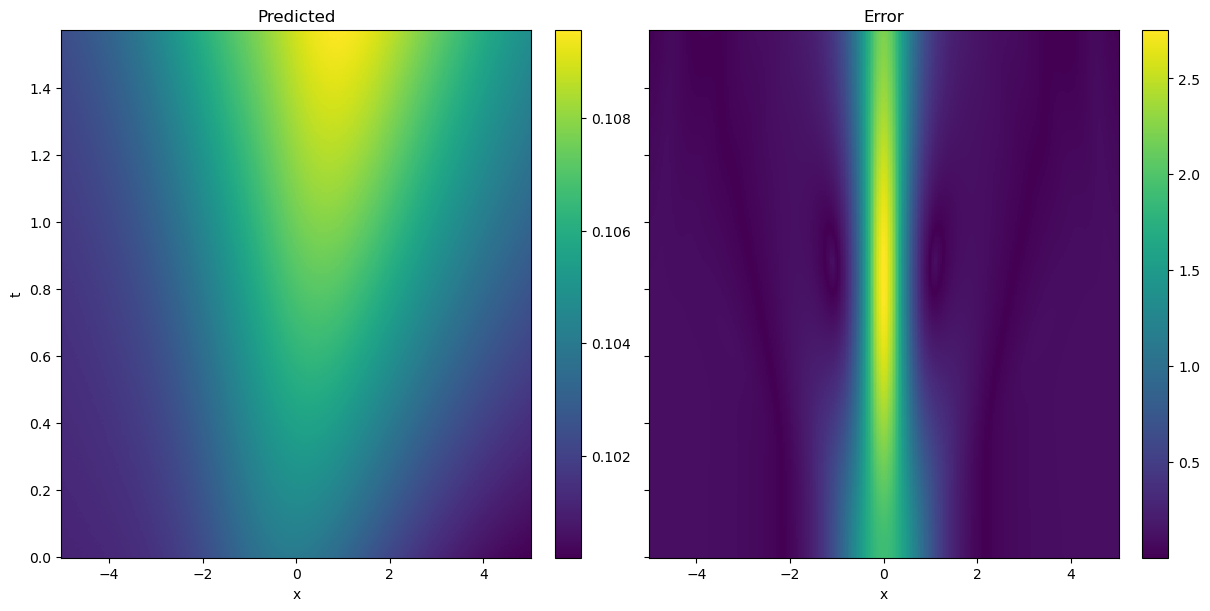

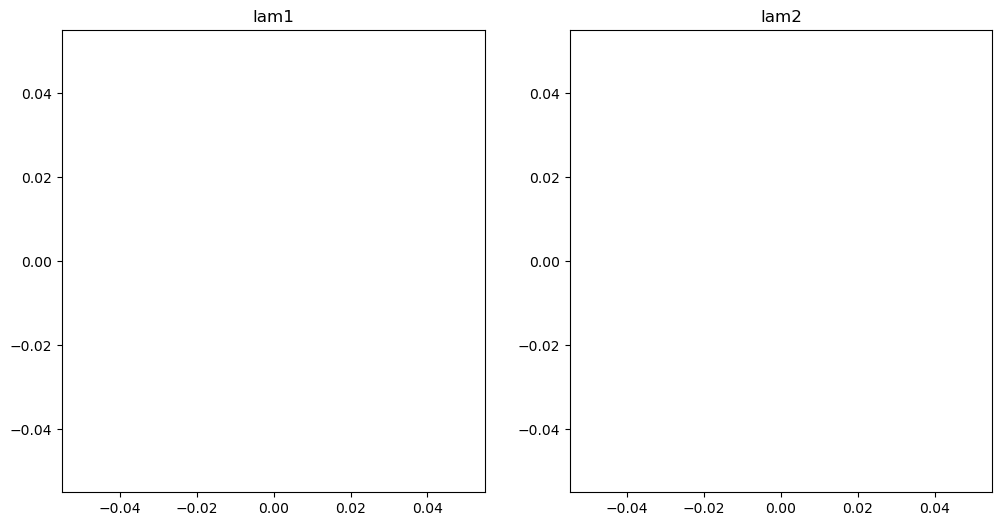

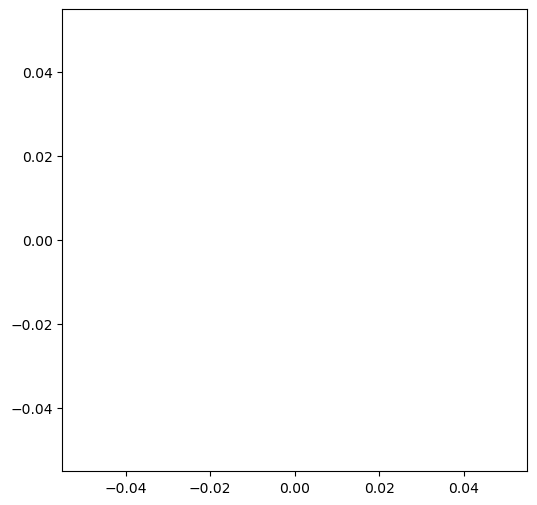

Step: 500, Loss: 0.3294928967952728
U data loss: 0.1393318474292755, U func loss: 0.022034086287021637
V data loss: 0.1309087574481964, V func loss: 0.03721821308135986
Lam1: 0.1995, lam2: 0.5264
Step: 1000, Loss: 0.045531414449214935
U data loss: 0.018175462260842323, U func loss: 0.007577431853860617
V data loss: 0.012845543213188648, V func loss: 0.00693297665566206
Lam1: 0.2764, lam2: 0.5863
Step: 1500, Loss: 0.026043357327580452
U data loss: 0.01051168330013752, U func loss: 0.004170911852270365
V data loss: 0.007770370226353407, V func loss: 0.0035903924144804478
Lam1: 0.3087, lam2: 0.6098
Step: 2000, Loss: 0.022165361791849136
U data loss: 0.007987841963768005, U func loss: 0.004574508406221867
V data loss: 0.0065077864564955235, V func loss: 0.003095223568379879
Lam1: 0.3311, lam2: 0.6298
Step: 2500, Loss: 0.01685381680727005
U data loss: 0.006545958109200001, U func loss: 0.002531719394028187
V data loss: 0.005441810004413128, V func loss: 0.002334329765290022
Lam1: 0.3483, la

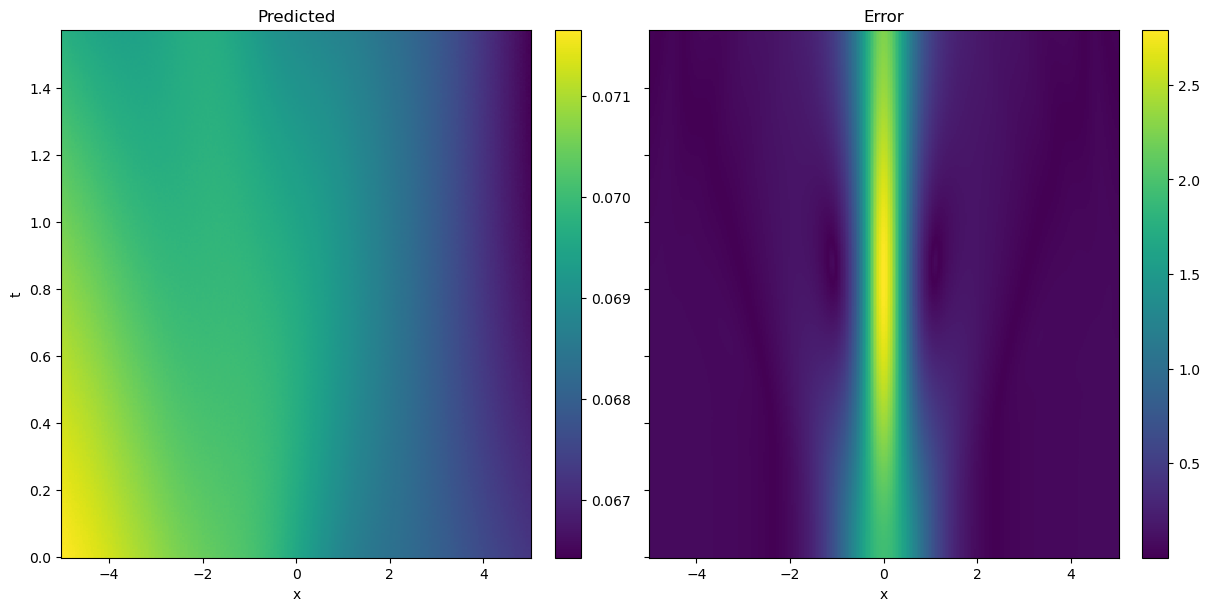

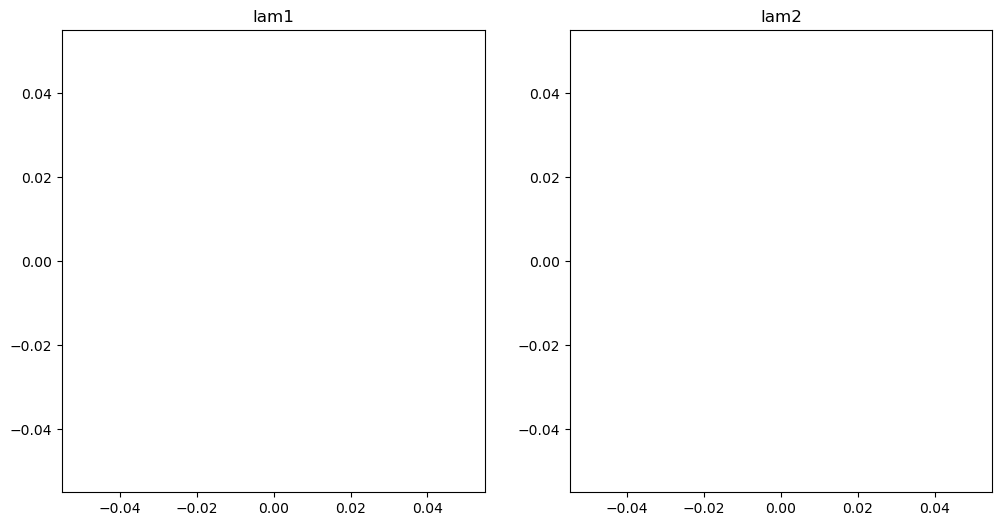

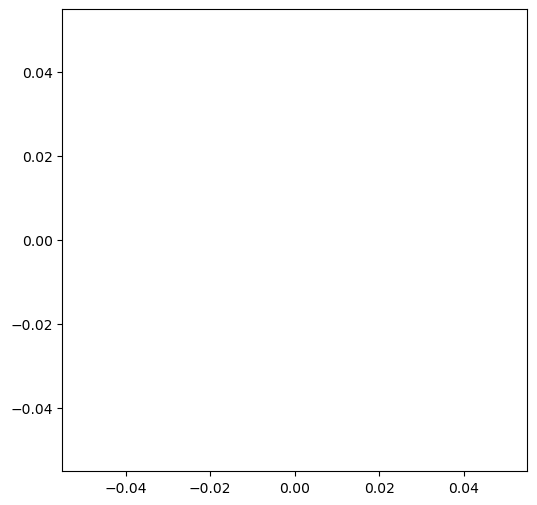

Step: 500, Loss: 0.14325153827667236
U data loss: 0.0741385668516159, U func loss: 0.007775928825139999
V data loss: 0.050286032259464264, V func loss: 0.011051010340452194
Lam1: 0.255, lam2: 0.5501
Step: 1000, Loss: 0.03773285448551178
U data loss: 0.015921147540211678, U func loss: 0.0047554923221468925
V data loss: 0.01064721867442131, V func loss: 0.006408995017409325
Lam1: 0.3088, lam2: 0.5786
Step: 1500, Loss: 0.02290263958275318
U data loss: 0.009869000874459743, U func loss: 0.0028916937299072742
V data loss: 0.00747008016332984, V func loss: 0.0026718659792095423
Lam1: 0.3383, lam2: 0.6062
Step: 2000, Loss: 0.01855807937681675
U data loss: 0.007557529956102371, U func loss: 0.0020775245502591133
V data loss: 0.006135746371001005, V func loss: 0.0027872787322849035
Lam1: 0.3609, lam2: 0.6316
Step: 2500, Loss: 0.019635776057839394
U data loss: 0.007360025309026241, U func loss: 0.002780053997412324
V data loss: 0.00694819912314415, V func loss: 0.0025474962312728167
Lam1: 0.3787

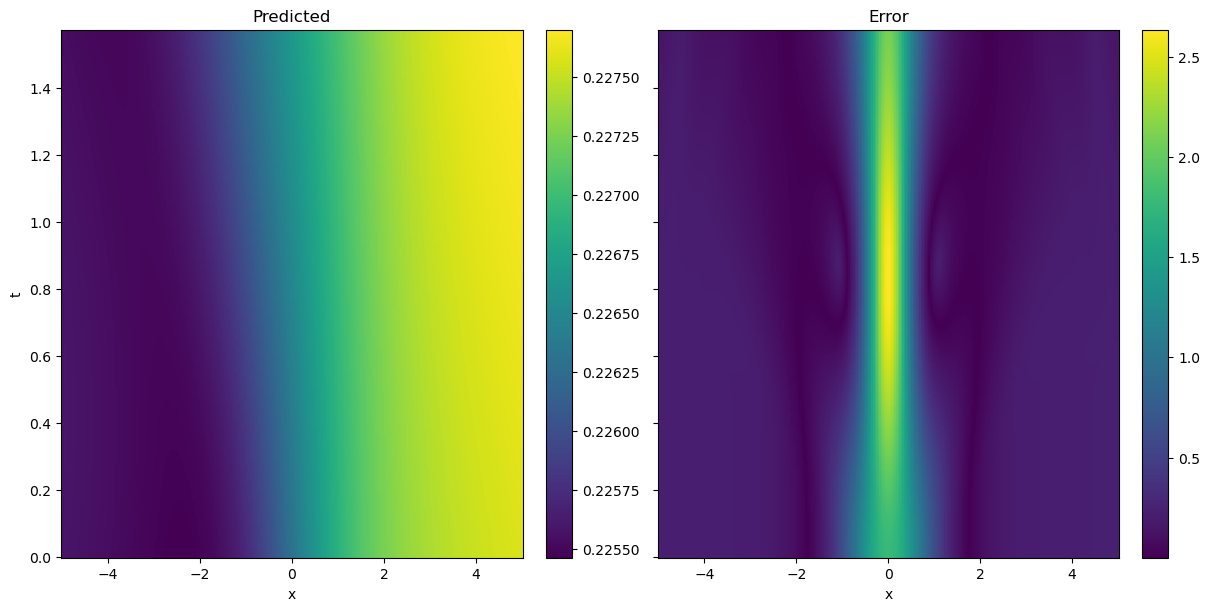

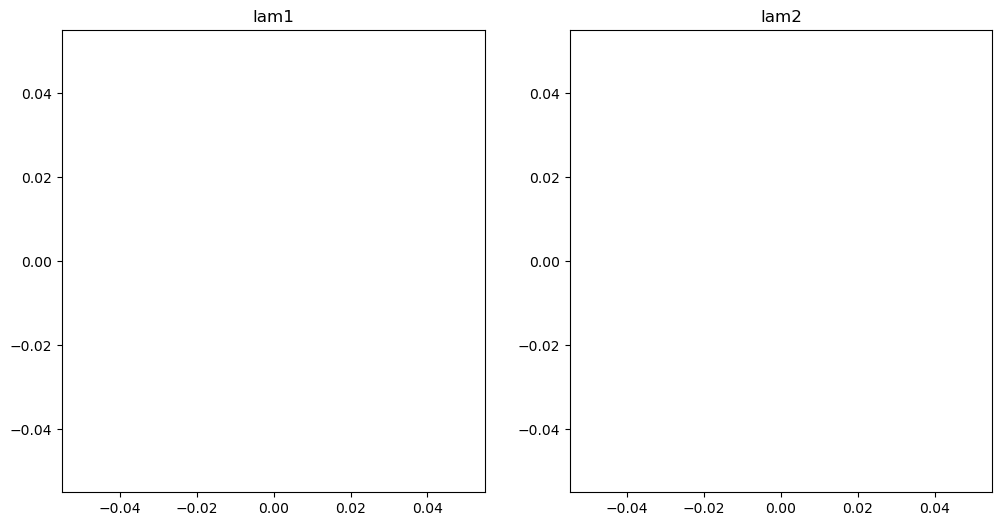

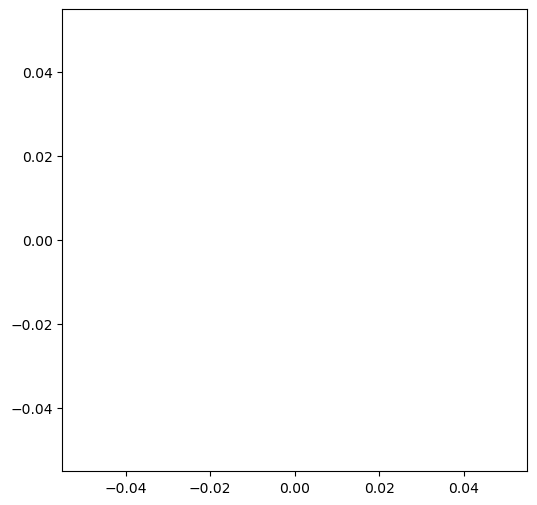

Step: 500, Loss: 0.3850724697113037
U data loss: 0.1707449108362198, U func loss: 0.016370415687561035
V data loss: 0.17431768774986267, V func loss: 0.02363945171236992
Lam1: 0.1749, lam2: 0.4627
Step: 1000, Loss: 0.15388381481170654
U data loss: 0.07233084738254547, U func loss: 0.012544023804366589
V data loss: 0.05056406930088997, V func loss: 0.018444882705807686
Lam1: 0.1735, lam2: 0.5935
Step: 1500, Loss: 0.08148030936717987
U data loss: 0.03842197358608246, U func loss: 0.006851521786302328
V data loss: 0.024754377081990242, V func loss: 0.01145243365317583
Lam1: 0.2317, lam2: 0.6343
Step: 2000, Loss: 0.047875721007585526
U data loss: 0.02063933201134205, U func loss: 0.005021076183766127
V data loss: 0.011770399287343025, V func loss: 0.010444913059473038
Lam1: 0.2721, lam2: 0.659
Step: 2500, Loss: 0.03295842185616493
U data loss: 0.013739478774368763, U func loss: 0.0032965978607535362
V data loss: 0.007646385580301285, V func loss: 0.008275958709418774
Lam1: 0.3013, lam2: 0.

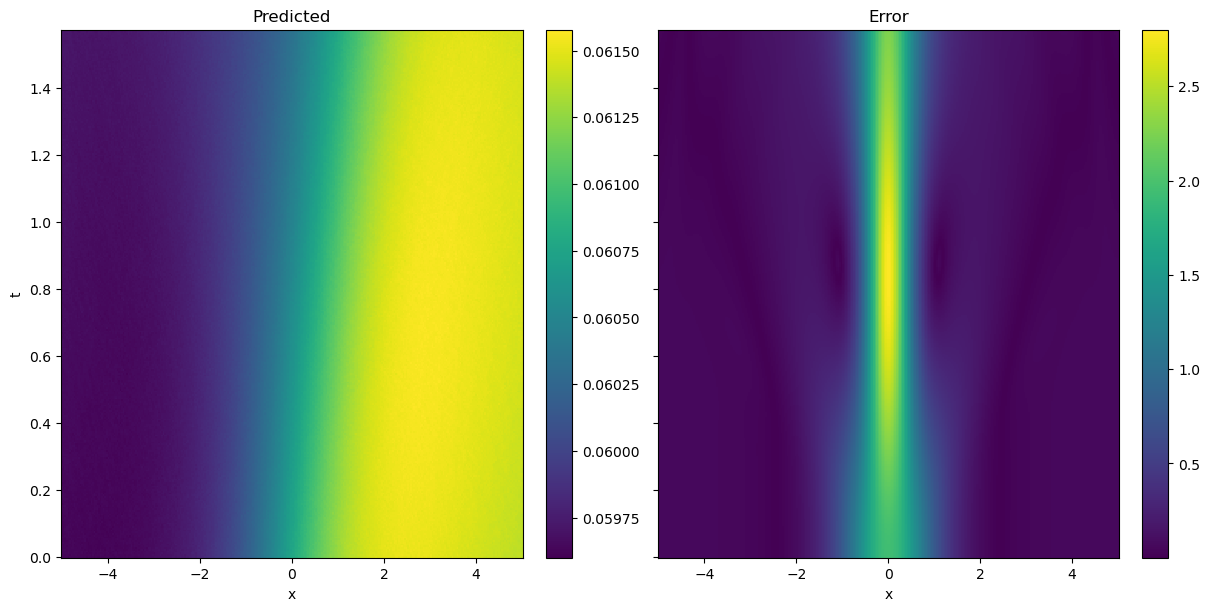

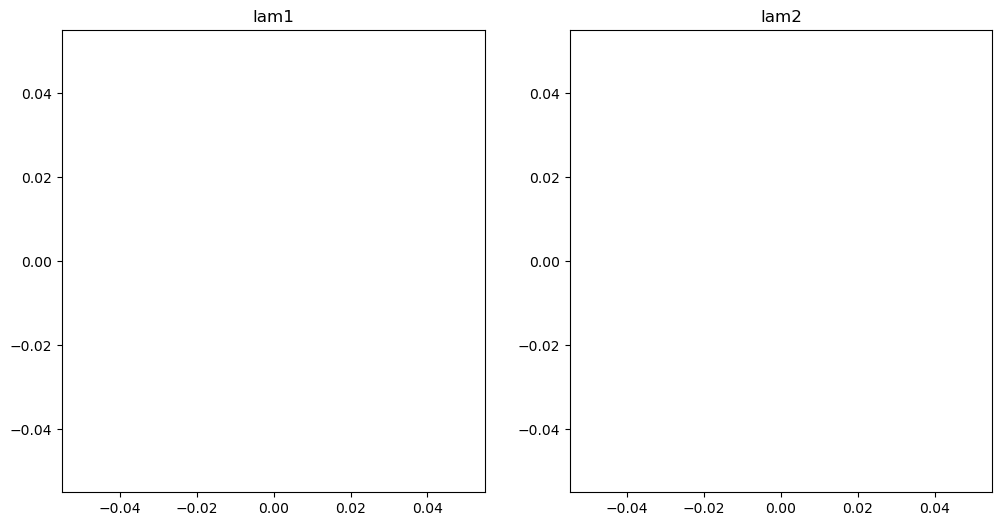

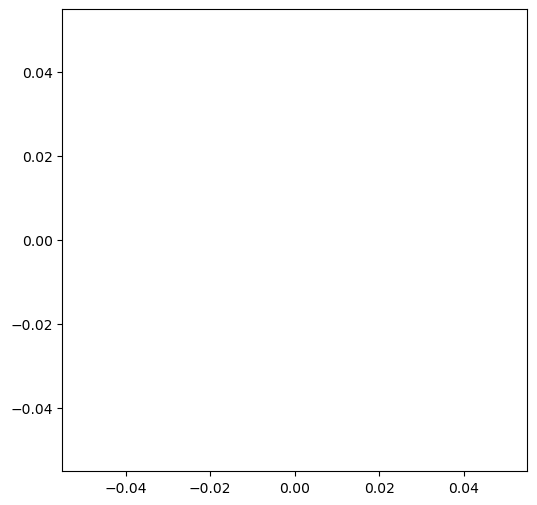

Step: 500, Loss: 0.37022143602371216
U data loss: 0.15652403235435486, U func loss: 0.0200860146433115
V data loss: 0.16297547519207, V func loss: 0.03063592128455639
Lam1: 0.1615, lam2: 0.4637
Step: 1000, Loss: 0.11401459574699402
U data loss: 0.05433402955532074, U func loss: 0.01470429077744484
V data loss: 0.03336325287818909, V func loss: 0.011613023467361927
Lam1: 0.1642, lam2: 0.5702
Step: 1500, Loss: 0.05364537611603737
U data loss: 0.02231118083000183, U func loss: 0.009512827731668949
V data loss: 0.014572890475392342, V func loss: 0.007248479872941971
Lam1: 0.2199, lam2: 0.5941
Step: 2000, Loss: 0.03875574842095375
U data loss: 0.014948831871151924, U func loss: 0.00666425283998251
V data loss: 0.011164382100105286, V func loss: 0.005978283006697893
Lam1: 0.2557, lam2: 0.6144
Step: 2500, Loss: 0.0283547081053257
U data loss: 0.011143631301820278, U func loss: 0.005104282405227423
V data loss: 0.008362313732504845, V func loss: 0.0037444820627570152
Lam1: 0.2844, lam2: 0.6362

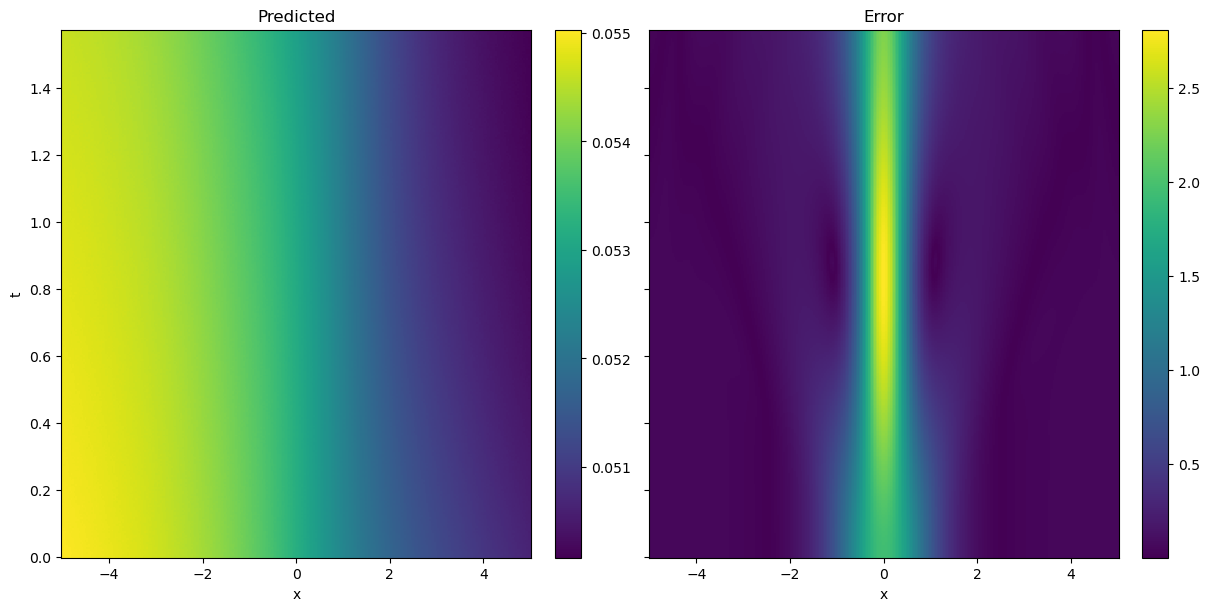

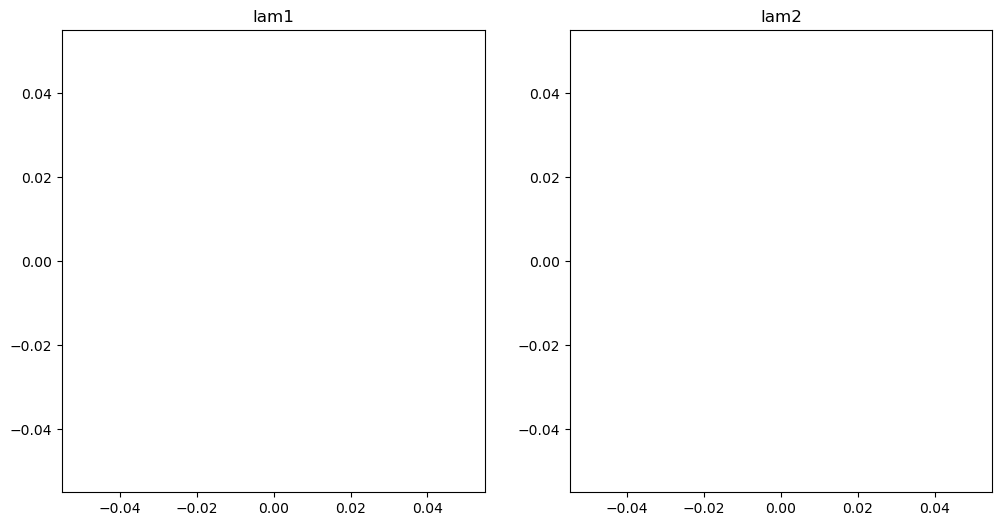

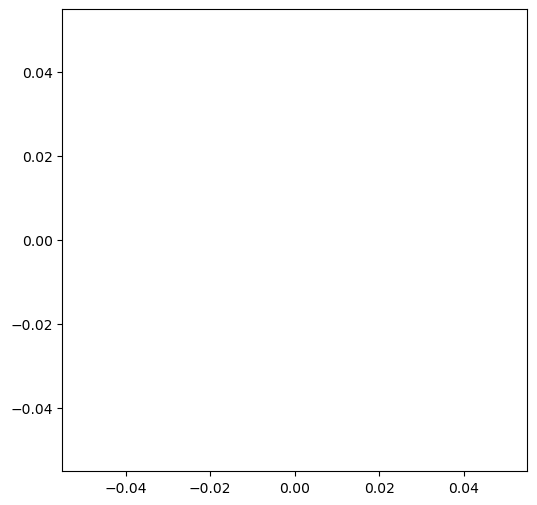

Step: 500, Loss: 0.18855662643909454
U data loss: 0.09384098649024963, U func loss: 0.014387350529432297
V data loss: 0.06304377317428589, V func loss: 0.017284516245126724
Lam1: 0.2419, lam2: 0.541
Step: 1000, Loss: 0.06661490350961685
U data loss: 0.029606055468320847, U func loss: 0.008948520757257938
V data loss: 0.02066011168062687, V func loss: 0.007400217466056347
Lam1: 0.3116, lam2: 0.5715
Step: 1500, Loss: 0.040744975209236145
U data loss: 0.016924947500228882, U func loss: 0.006808693055063486
V data loss: 0.011323992162942886, V func loss: 0.005687341559678316
Lam1: 0.3483, lam2: 0.5915
Step: 2000, Loss: 0.029594598338007927
U data loss: 0.01199332345277071, U func loss: 0.005396985448896885
V data loss: 0.008162740617990494, V func loss: 0.004041551146656275
Lam1: 0.3742, lam2: 0.6092
Step: 2500, Loss: 0.03727678209543228
U data loss: 0.010954074561595917, U func loss: 0.006794060114771128
V data loss: 0.00675310380756855, V func loss: 0.0127755431458354
Lam1: 0.3942, lam2:

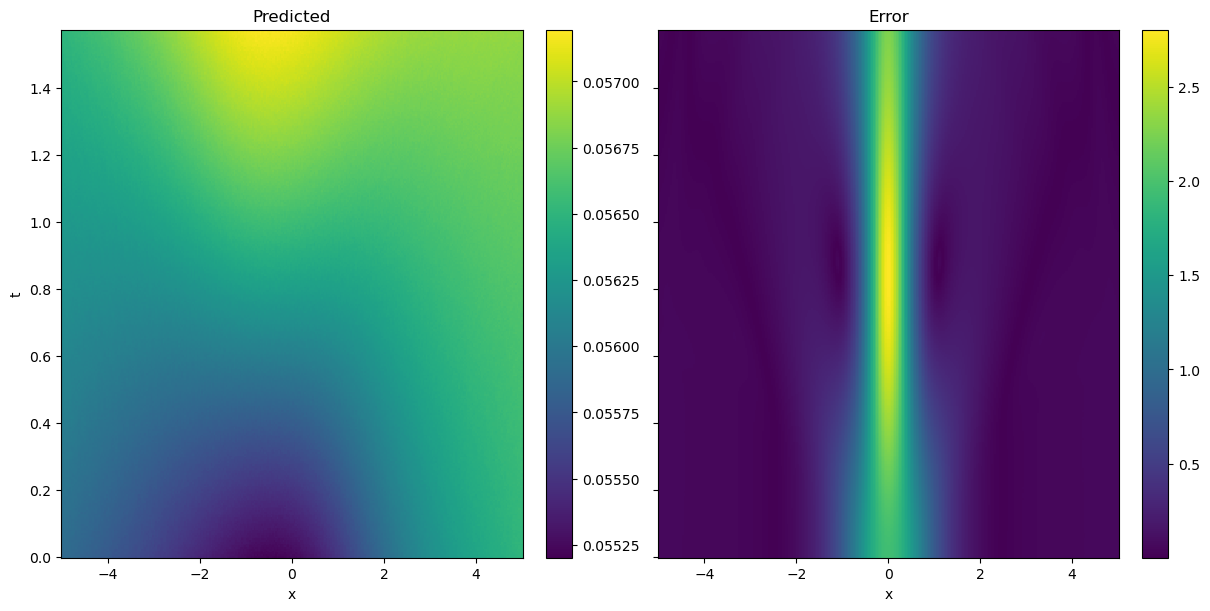

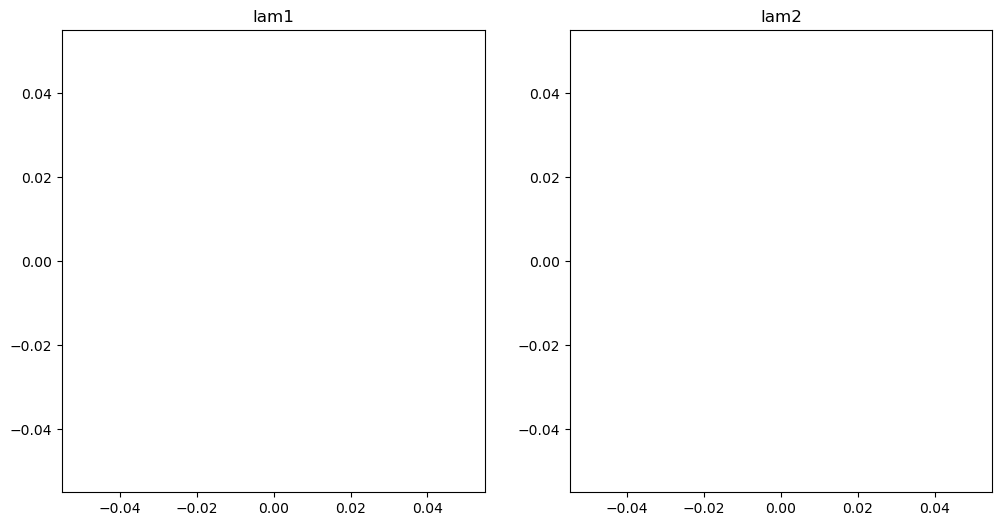

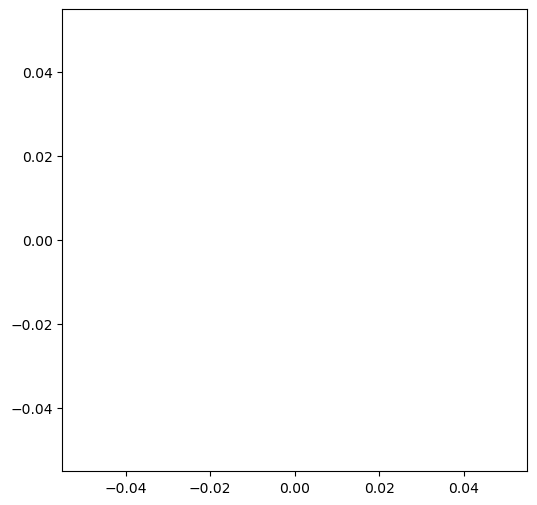

Step: 500, Loss: 0.18622790277004242
U data loss: 0.07322915643453598, U func loss: 0.025340665131807327
V data loss: 0.06568503379821777, V func loss: 0.02197304181754589
Lam1: 0.2526, lam2: 0.519
Step: 1000, Loss: 0.03594234213232994
U data loss: 0.014630598947405815, U func loss: 0.005674409680068493
V data loss: 0.011198461055755615, V func loss: 0.004438874311745167
Lam1: 0.2987, lam2: 0.5445
Step: 1500, Loss: 0.023633362725377083
U data loss: 0.010622045956552029, U func loss: 0.002322761109098792
V data loss: 0.007826302200555801, V func loss: 0.002862251829355955
Lam1: 0.3281, lam2: 0.5678
Step: 2000, Loss: 0.017778830602765083
U data loss: 0.008206546306610107, U func loss: 0.0018191280541941524
V data loss: 0.006133732385933399, V func loss: 0.0016194249037653208
Lam1: 0.3523, lam2: 0.5901
Step: 2500, Loss: 0.051023125648498535
U data loss: 0.008003388531506062, U func loss: 0.01932797208428383
V data loss: 0.007805967703461647, V func loss: 0.015885796397924423
Lam1: 0.3739,

,2,4,6,8,10
0,0.011081,0.004950,0.006155,0.010155,0.012112
1,0.003347,0.004519,0.006283,0.009891,0.013431
2,0.003881,0.005406,0.007180,0.008276,0.011979
3,0.002989,0.005545,0.009446,0.012780,0.011021


In [12]:
df = pd.DataFrame(columns=[2,4,6,8,10])
for n_layers in [2,4,6,8,10]:
    print('%%%%%%%%%%%%%%%')
    print(str(n_layers))
    print('%%%%%%%%%%%%%%%')
    tmp = []
    for dim in [32,64,128,256]:
        print('########' + str(dim) + '##########')
        model = PINN(x_train, t_train, u_train, v_train, dDim=dim, nHid=n_layers)
        model.train(5000)
        tmp.append(model.ls.item())
    df[n_layers] = pd.Series(tmp)

df